<div class="alert alert-block alert-success">
<center><b>AIM404 : Contextual Bandits with Amazon SageMaker RL</b></center>
</div>

We demonstrate how you can manage your own contextual multi-armed bandit workflow on SageMaker using the built-in [Vowpal Wabbit (VW)](https://github.com/VowpalWabbit/vowpal_wabbit) container to train and deploy contextual bandit models. We show how to train these models that interact with a live environment (using a simulated client application) and continuously update the model with efficient exploration.

### Why Contextual Bandits?

Wherever we look to personalize content for a user (content layout, ads, search, product recommendations, etc.), contextual bandits come in handy. Traditional personalization methods collect a training dataset, build a model and deploy it for generating recommendations. However, the training algorithm does not inform us on how to collect this dataset, especially in a production system where generating poor recommendations lead to loss of revenue. Contextual bandit algorithms help us collect this data in a strategic manner by trading off between exploiting known information and exploring recommendations which may yield higher benefits. The collected data is used to update the personalization model in an online manner. Therefore, contextual bandits help us train a personalization model while minimizing the impact of poor recommendations.

### What does this notebook contain?

To implement the exploration-exploitation strategy, we need an iterative training and deployment system that: (1) recommends an action using the contextual bandit model based on user context, (2) captures the implicit feedback over time and (3) continuously trains the model with incremental interaction data. In this notebook, we show how to setup the infrastructure needed for such an iterative learning system. While the example demonstrates a bandits application, these continual learning systems are useful more generally in dynamic scenarios where models need to be continually updated to capture the recent trends in the data (e.g. tracking fraud behaviors based on detection mechanisms or tracking user interests over time). 

In a typical supervised learning setup, the model is trained with a SageMaker training job and it is hosted behind a SageMaker hosting endpoint. The client application calls the endpoint for inference and receives a response. In bandits, the client application also sends the reward (a score assigned to each recommendation generated by the model) back for subsequent model training. These rewards will be part of the dataset for the subsequent model training. 

<p align="center">
  <img src="images/AIM404-workflow.png">
</p>

The contextual bandit training workflow is controlled by an experiment manager provided with this example. The client application (say a recommender system application) pings the SageMaker hosting endpoint that is serving the bandits model. The application sends the state (user features) as input and receives an action (recommendation) as a response. The client application sends the recommended action to the user and stores the received reward in S3. The SageMaker hosted endpoint also stores inference data (state and action) in S3. The experiment manager joins the inference data with rewards as they become available. The joined data is used to update the model with a SageMaker training job. The updated model is evaluated offline and deployed to SageMaker hosting endpoint if the model evaluation score improves upon prior models. 

Below is an overview of the subsequent cells in the notebook: 
* <a href='#configuration'>Configuration:</a> this includes details related to SageMaker and other AWS resources needed for the bandits application. 
* <a href='#iam-role-setup'>IAM role setup:</a> this creates appropriate execution role and shows how to add more permissions to the role, needed for specific AWS resources.
* <a href='#client-application'>Client application (Environment):</a> this shows the simulated client application.
* <a href='#step-by-step'>Step-by-step bandits model development:</a> 
 1. Model Initialization (random or warm-start) and evaluation
 2. Deploy the First Model 
 3. Initialize the Client Application : Start Inference
 4. Reward Ingestion 
 5. Model Re-training and Re-deployment 
* <a href='#end-to-end'>Bandits model deployment with the end-to-end loop</a>
* <a href='#clean-up'>Cleanup</a>

### Conventions - Markdown colors convention
In all notebooks, there is color convention on the cells:
<div class="alert alert-block alert-warning"><b>Yellow cells</b>: These cells give you context on the steps or work expected within a notebook</div> 
<div class="alert alert-block alert-info"><b>Blue cells</b>: These cells contain actions that you will run or execute</div>
<div class="alert alert-block alert-success"><b>Green cells</b>: These cells give a summary report of what you have accomplished so far in a notebook</div>
<div class="alert alert-block alert-danger""><b>Red cells</b>: These cells give an alert or a warning for an action for participants to pay attention</div>

<a id='configuration'></a>
## Configuration

To facilitate experimentation, we provide a `local_mode` that runs the contextual bandit example using the SageMaker Notebook instance itself instead of SageMaker training and hosting instances. The workflow remains the same in `local_mode`, but runs much faster for small datasets. Hence, it is a useful tool for experimentation and debugging. However, it will not scale to production use cases with high throughput and large datasets. 

In `local_mode`, the training, evaluation and hosting is done with the SageMaker VW docker container. The join is not handled by SageMaker, and is done inside the client application. The rest of the textual explanation assumes that the notebook is run in SageMaker mode.

In [2]:
import yaml
import sys
import numpy as np
import time
import sagemaker
import pprint
import pandas as pd
sys.path.append('common')
sys.path.append('common/sagemaker_rl')
from misc import get_execution_role
from markdown_helper import *
from IPython.display import Markdown
from IPython.core.display import Image, display, HTML

<div class="alert alert-block alert-danger"">
<b>IMPORTANT :</b> You need to run the notebook with Sagemaker only, so you need to configure the following value in config.yaml file 
<ul>
                                            <li>local_mode: <b>false</b></li>
                                            <li>soft_deployment: <b>false</b></li>
</ul>
</div>

In [3]:
!pygmentize 'config.yaml'
config_file = 'config.yaml'
with open(config_file, 'r') as yaml_file:
    config = yaml.load(yaml_file)

resource:
  shared_resource:
    # cloud formation stack
    resources_cf_stack_name: "BanditsSharedResourceStack"
    # Dynamo table for status of an experiment
    experiment_db:
      table_name: "BanditsExperimentTable"
    # Dynamo table for status of all models trained
    model_db:
      table_name: "BanditsModelTable"
    # Dynamo table for status of all joining job for reward ingestion
    join_db:
      table_name: "BanditsJoinTable"
    iam_role:
      role_name: "BanditsIAMRole"
  private_resource:
    hosting_fleet:
      instance_type: "ml.t2.medium"
      instance_count: 1
    training_fleet:
      instance_type: "ml.c5.4xlarge"
    evaluation_fleet:
      instance_type: "ml.c5.4xlarge"
# Vowpal Wabbit container
image: "462105765813.dkr.ecr.{AWS_REGION}.amazonaws.com/sagemaker-rl-vw-container:vw-8.7.0-cpu"
# Vowpal Wabbit algorithm parameters
algor:
  algorithms_parameters:
    exploration_policy: "egreedy" # supports "egreedy", "bag", "cover"
    epsilon: 0.001 # used i

#### Vowpal Wabbit 

Let's do a deep dive on the Vowpal Wabbit (VW) configuration!

> A container for Vowpal Wabbit is already provisionned by AWS and available here : 
`462105765813.dkr.ecr.<region>.amazonaws.com/sagemaker-rl-vw-container:vw-8.7.0-cpu`.

This container is built and maintained by AWS Teams but you can access the DockerFile!




<div class="alert alert-block alert-info">
§ Open the <a href="https://github.com/aws/sagemaker-rl-container/blob/master/vw/docker/8.7.0/Dockerfile">Vowpal Wabbit Dockerfile</a>
</div>

VW supports multiple **Contextual Bandit algorithms**:

- Explore-first
- **Epsilon-greedy** - egreedy
- **Bagging Explorer** - bag
- **Online Cover** - cover


> Please make sure that the `num_arms` parameter in the config is equal to the number of actions in the client application (which is defined in the cell below).

<a id='iam-role-setup'></a>
## IAM role setup
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use `utils` method `role = get_execution_role('role_name')` to create an execution role.

<div class="alert alert-block alert-warning">
    Retrieve Sagemaker IAM role arn
</div/>

In [4]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::573875878481:role/workshop-AIM-404-role


<a id='client-application'></a>
## Client application (Environment) 

#### [Statlog (Shuttle) Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle))

<div class="alert alert-block alert-warning">
    It contains <b>nine integer attributes (or features)</b> related to indicators during a space shuttle flight, and the goal is to predict one of seven states of the radiator subsystem of the shuttle.
    
   It can be seen as a multi-class classification problem with 9 features and 7 classes. In the classification problem, the algorithm receives features and correct label per datapoint.
    
   Here, we convert this multi-class classifcation problem to a <b>bandit problem.</b>
    
   The algorithm picks one of the label (arm) options given the features (context). If this matches the class in the original data point, a reward of one is assigned. If not, a reward of zero is assigned.
</div/>

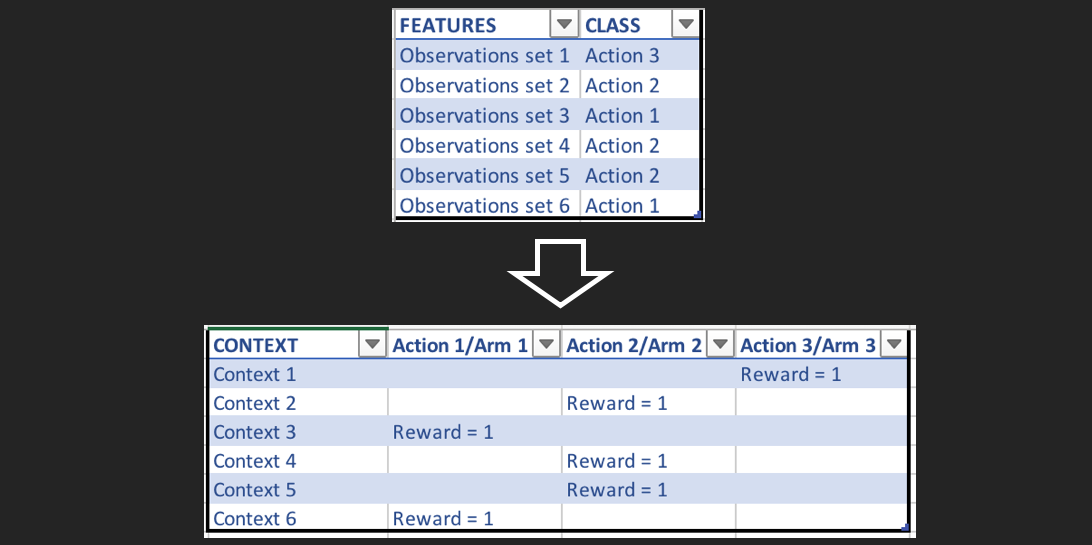

In [5]:
display(Image('images/AIM404-classification-bandits.png'))

The client application simulates a live environment that uses **the SageMaker bandits model to serve recommendations to users**. The logic of reward generation resides in the client application.

The workflow of the client application is as follows:
- The client application picks a context at random, which is sent to the SageMaker endpoint for retrieving an action.
- SageMaker endpoint returns an action, associated probability and `event_id`.
- Since this simulator was generated from the Statlog dataset, we know the true class for that context. 
- The application reports the reward to the experiment manager using S3, along with the corresponding `event_id`.

`event_id` is a unique identifier for each interaction. It is used to join inference data `<state, action, action probability>` with the rewards. 

In a later cell of this notebook, where there exists a hosted endpoint, we illustrate how the client application interacts with the endpoint and gets the recommended action.

The shuttle data set is stored under **sim_app/shuttle.trn**

They are actually 2 scripts that will help us simulate our application : 
* sim_app_utils.py
* statlog_sim_app.py

In [6]:
sys.path.append('sim_app')
from statlog_sim_app import StatlogSimApp

In [7]:
!pygmentize sim_app/sim_app_utils.py

from statlog_sim_app import remove_underrepresented_classes, classification_to_bandit_problem
import numpy as np
import pandas as pd
import boto3
from src.io_utils import parse_s3_uri

def prepare_statlog_warm_start_data(data_file, batch_size):
    """
    Generate a batch of experiences for warm starting the policy.
    """
    num_actions = 7
    joined_data_buffer = []

    with open(data_file, 'r') as f:
        data = np.loadtxt(f)

    # Shuffle data
    np.random.shuffle(data)

    # Last column is label, rest are features
    contexts = data[:, :-1]
    labels = data[:, -1].astype(int) - 1  # convert to 0 based index

    context, labels = remove_underrepresented_classes(contexts, labels)
    statlog_context, statlog_labels, _ = classification_to_bandit_problem(
                                    context, labels, num_actions)

    for i in range(0, batch_size):
        context_index_i = np.random.choice(statlog_context.shape[0])
        context_i = statlog_context[context_inde

In [8]:
!pygmentize sim_app/statlog_sim_app.py

import pandas as pd
import time
import uuid
import boto3
from urllib.parse import urlparse
import datetime
import json
import io
import numpy as np

def remove_underrepresented_classes(features, labels, thresh=0.0005):
    """Removes classes when number of datapoints fraction is below a threshold."""
    total_count = labels.shape[0]
    unique, counts = np.unique(labels, return_counts=True)
    ratios = counts.astype('float') / total_count
    vals_and_ratios = dict(zip(unique, ratios))
    print('Unique classes and their ratio of total: %s' % vals_and_ratios)
    keep = [vals_and_ratios[v] >= thresh for v in labels]
    return features[keep], labels[np.array(keep)]

def safe_std(values):
    """Remove zero std values for ones."""
    return np.array([val if val != 0.0 else 1.0 for val in values])

def classification_to_bandit_problem(contexts, labels, num_actions=None):
    """Normalize contexts and encode deterministic rewards."""
    if num_actions is None:
        num_actions = np

<a id='step-by-step'></a>
## Step-by-step bandits model development

`ExperimentManager` is the top level class for all the Bandits/RL and continual learning workflows. Similar to the estimators in the [Sagemaker Python SDK](https://github.com/aws/sagemaker-python-sdk), `ExperimentManager` contains methods for training, deployment and evaluation. It keeps track of the job status and reflects current progress in the workflow.

Start the application using the `ExperimentManager` class. Information about the class can be found here : **/common/sagemaker_rl/orchestrator/workflow/manager/experiment_manager.py**

<div class="alert alert-block alert-warning">
    <b>Experiment Manager Methods </b>

***Training***

- initialize_first_model( ) : Initializes the first Model training for an Experiment
- evaluate_model( ) : Start an evaluation job to evaluate a model
- train_next_model( ) : Train a new model given the training data and a pretrained model

***Inference***

- deploy_model( ) : Deploy a new model by creating a new hosting endpoint or update the model hosted by an existing endpoint
- predictor( ) : Create a predictor
- get_eval_score( ) :  Return evaluation score given model id and evaluation data path

***Data Aggregation***

- ingest_rewards( ) : Upload rewards data in a rewards buffer to S3 bucket
- ingest_joined_data( ) : Upload joined data in joined data buffer to S3 bucket
- join( ) : Start a joining job given rewards data path and observation data time window

***Logging***

- get_cloudwatch_dashboard_details( ) : Get detail from cloudwatch 

***Clean-up***

- clean_resource( ) : Clean up resource of the given experiment, including hosting endpoint and firehose stream
- clean_table_records( ) : Clean up all related records of a given experiment
</div/>

In [9]:
from orchestrator.workflow.manager.experiment_manager import ExperimentManager

 The initialization below will set up an AWS CloudFormation stack of additional resources. 

<div class="alert alert-block alert-danger"">
<b>IMPORTANT:</b> Enter the name of your Experiment here : 
<ul>
  <li>model_id length cannot exceed 63 characters under SM mode.</li>
  <li>evaluation job name will include timestamp in addition to train job name so, make experimend_id as short as possible</li>
</ul>
</div>

In [10]:
experiment_name = "AIM404-sbs" #YOUR EXPERIMENT NAME HERE - can be AIM404-1
bandits_experiment = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Creating a new CloudFormation stack for Shared Resources. You can always reuse this StackName in your other experiments
INFO:orchestrator.resource_manager:[
    {
        "ParameterKey": "IAMRoleName",
        "ParameterValue": "BanditsIAMRole",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbName",
        "ParameterValue": "BanditsExperimentTable",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbRCU",
        "ParameterValue": "5",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ExperimentDbWCU",
        "ParameterValue": "5",
        "UsePreviousValue": true,
        "ResolvedValue": "string"
    },
    {
        "ParameterKey": "ModelDbName",
        "ParameterValue": "BanditsModelTable",
        "UsePreviousValue": true,
        "ResolvedValue": "strin

<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/cloudformation/home?force&region=us-east-1">Cloudformation console</a> to understand which services are being setup
</div>

### 1. Model Initialization and evaluation

To start a new experiment, we need to initialize the first model. In the case where historical data is available and is in the format of `<state, action, action probability, reward>`, we can warm start by learning the policy offline. Otherwise, we can initiate a random policy.

**Warm start the policy**

We showcase the warm start by generating a batch of randomly selected samples with size `batch_size`. Then we split it into a training set and an evaluation set using the parameter `ratio`.

From sim_app/sim_app_utils.py, we use a tool that simulate an application

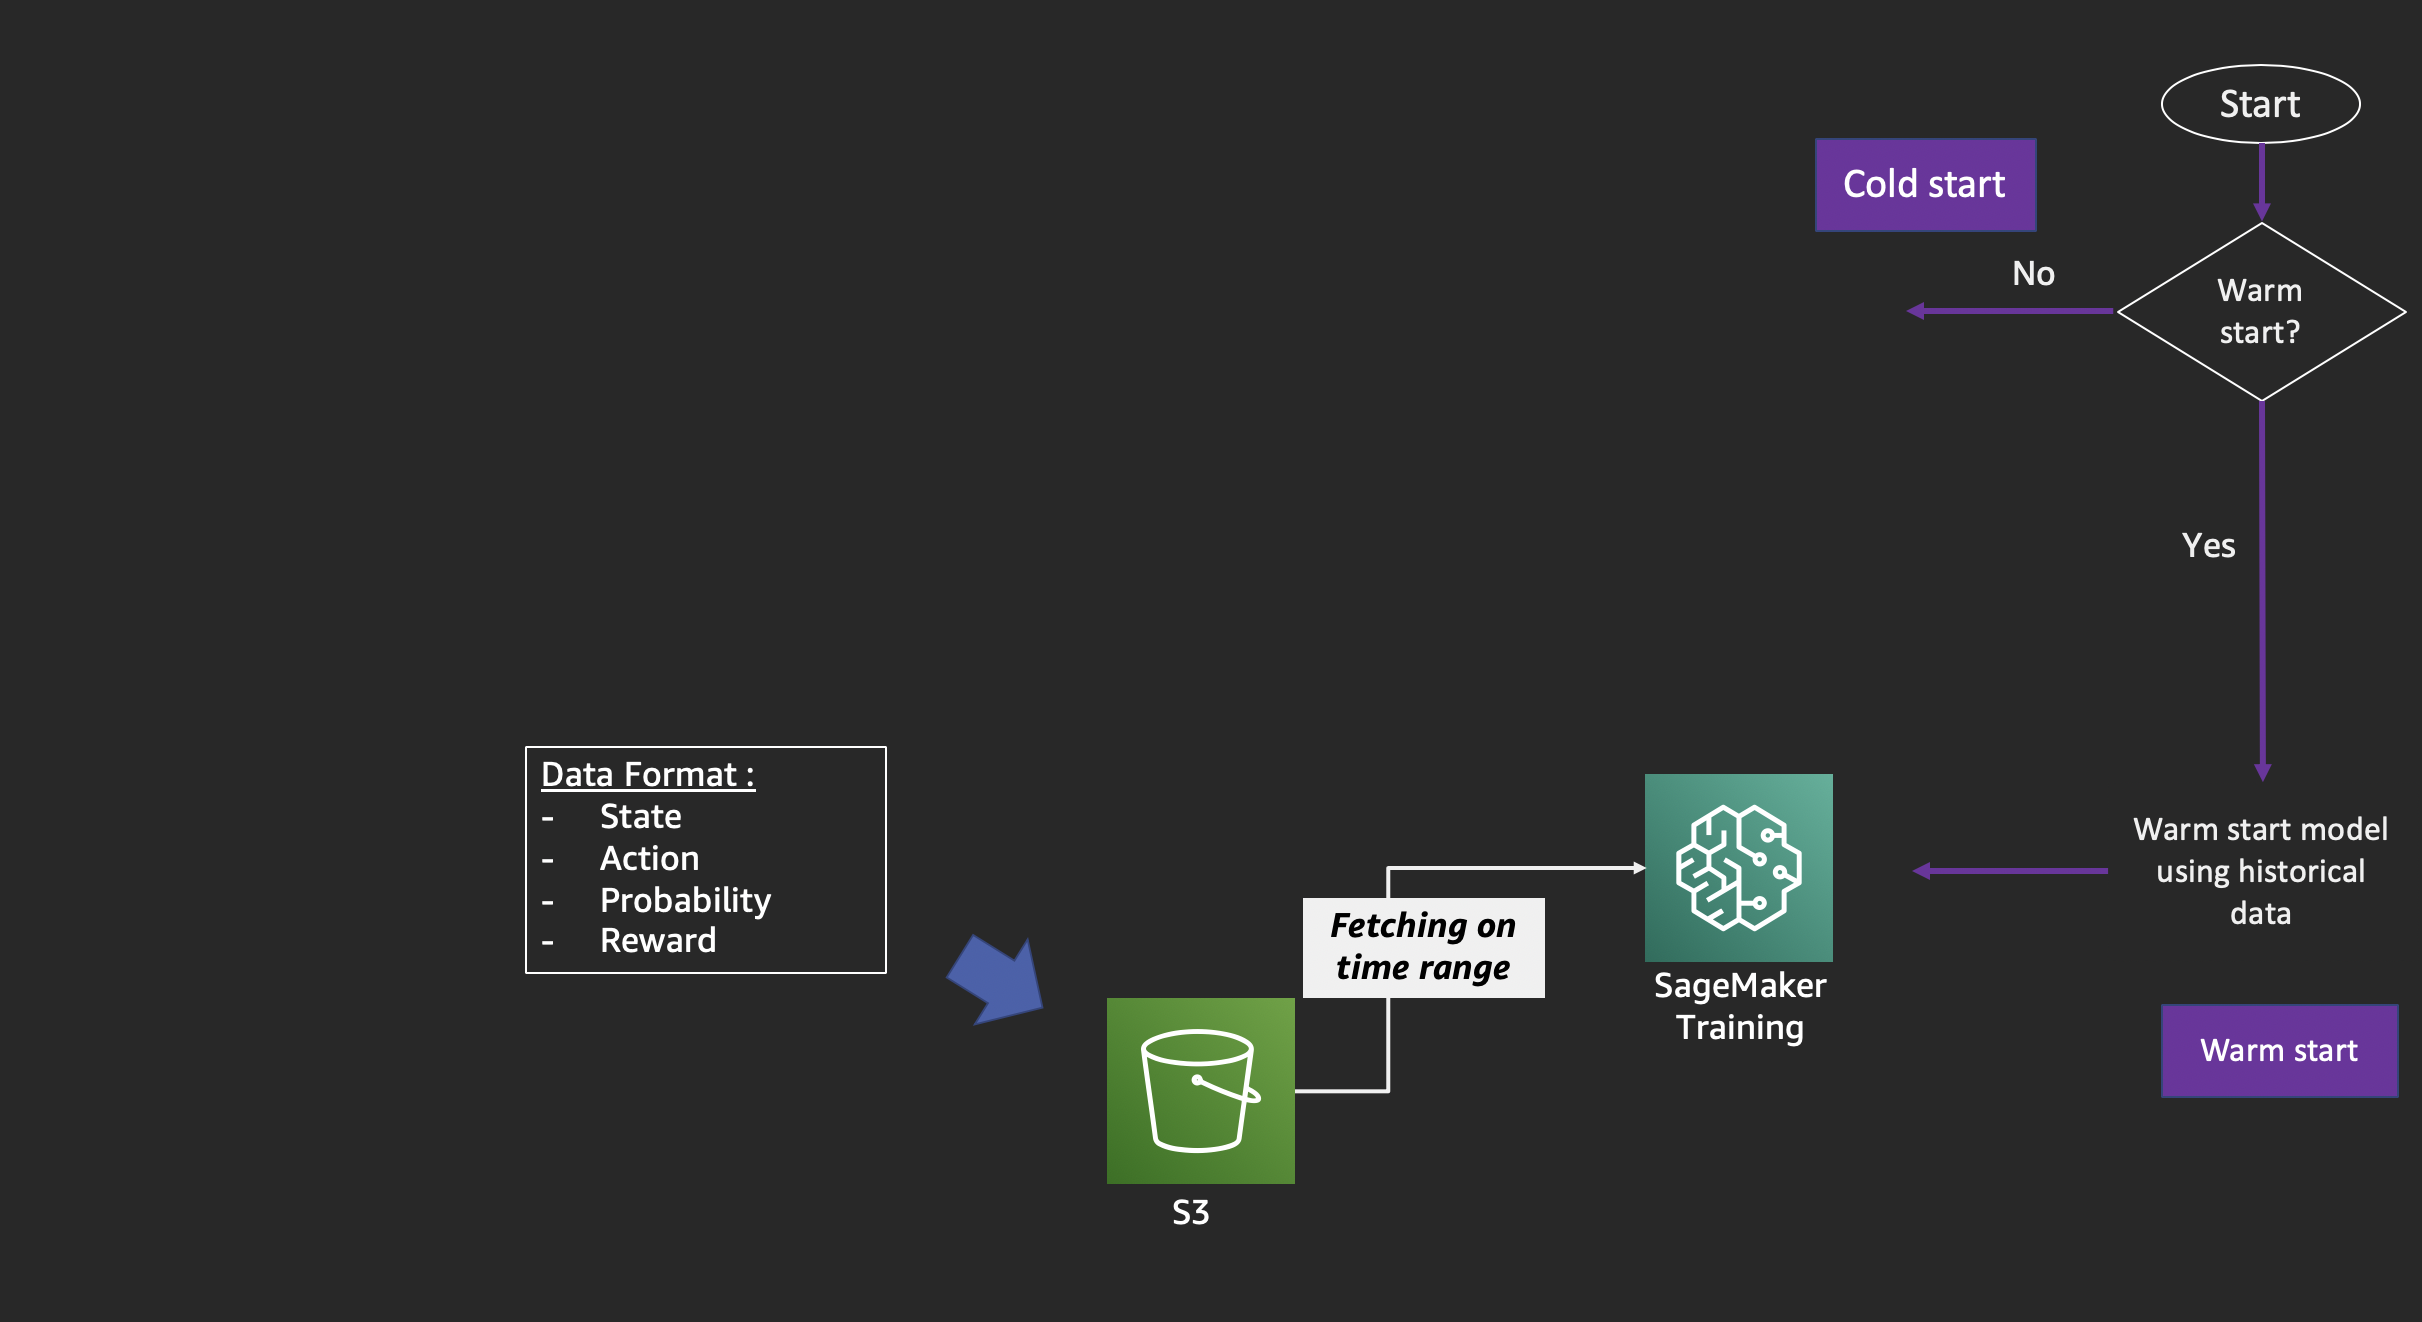

In [11]:
display(Image('images/AIM404-model-initialization.png'))

In [12]:
from sim_app_utils import *

batch_size = 100
warm_start_data_buffer = prepare_statlog_warm_start_data(data_file='sim_app/shuttle.trn', batch_size=batch_size)

# upload to s3
bandits_experiment.ingest_joined_data(warm_start_data_buffer,ratio=0.8)

Unique classes and their ratio of total: {0: 0.7840919540229885, 1: 0.0008505747126436781, 2: 0.0030344827586206895, 3: 0.1551264367816092, 4: 0.05650574712643678, 5: 0.00013793103448275863, 6: 0.0002528735632183908}


INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-573875878481' for athena queries
INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.8
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-east-1-573875878481/AIM404-sbs/joined_data/AIM404-sbs-join-job-id-1575490535


With prepare_statlog_warm_start_data() method, it randomly picks an action and generate the reward associated to the action picked!

<div class="alert alert-block alert-warning">
    <b>Check the status of bandits_experiment object</b>

It is composed of the following elements : 
- experiment_id
- evaluation_workflow_metadata
- hosting_workshow_metadata
- joining_workflow_metadata
- training_workflow_metadata
</div/>

In [13]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(bandits_experiment._jsonify())

{   'evaluation_workflow_metadata': {   'evaluation_state': None,
                                        'last_evaluation_job_id': None,
                                        'next_evaluation_job_id': None},
    'experiment_id': 'AIM404-sbs',
    'hosting_workflow_metadata': {   'hosting_endpoint': None,
                                     'hosting_state': None,
                                     'last_hosted_model_id': None,
                                     'next_model_to_host_id': None},
    'joining_workflow_metadata': {   'joining_state': 'SUCCEEDED',
                                     'last_joined_job_id': 'AIM404-sbs-join-job-id-1575490535',
                                     'next_join_job_id': None},
    'training_workflow_metadata': {   'last_trained_model_id': None,
                                      'next_model_to_train_id': None,
                                      'training_state': None}}


In [14]:
bandits_experiment.initialize_first_model(input_data_s3_prefix=bandits_experiment.last_joined_job_train_data) 

INFO:orchestrator:Next Model name would be AIM404-sbs-model-id-1575490542
INFO:orchestrator:Start training job for model 'AIM404-sbs-model-id-1575490542''
INFO:orchestrator:Training job will be executed in 'SageMaker' mode


2019-12-04 20:15:43 Starting - Starting the training job...
2019-12-04 20:15:44 Starting - Launching requested ML instances.........
2019-12-04 20:17:17 Starting - Preparing the instances for training...
2019-12-04 20:18:05 Downloading - Downloading input data
2019-12-04 20:18:05 Training - Downloading the training image.....2019-12-04 20:18:49,784 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:18:52,812 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:18:52,824 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:18:52,834 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_estimator": "RLEstimator"
    },
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": null,
    "hosts": [
        "algo-1"
    ],


<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/sagemaker/home?force&region=us-east-1#/jobs?f0=kvm%253AName%253AAIM404-sbs">Sagemaker console</a> to understand what is happening behind the scene
</div>

<div class="alert alert-block alert-warning">

The Experiment manager relies on [RLEstimator](https://sagemaker.readthedocs.io/en/stable/sagemaker.rl.html) from Sagemaker SDK to do the training and deployment.

The custom code for training is located in **train-vw.py** located in **src**
</div/>


In the experiment workflow, we have trained a specific model

In [15]:
pp.pprint(bandits_experiment._jsonify())

{   'evaluation_workflow_metadata': {   'evaluation_state': None,
                                        'last_evaluation_job_id': None,
                                        'next_evaluation_job_id': None},
    'experiment_id': 'AIM404-sbs',
    'hosting_workflow_metadata': {   'hosting_endpoint': None,
                                     'hosting_state': None,
                                     'last_hosted_model_id': None,
                                     'next_model_to_host_id': None},
    'joining_workflow_metadata': {   'joining_state': 'SUCCEEDED',
                                     'last_joined_job_id': 'AIM404-sbs-join-job-id-1575490535',
                                     'next_join_job_id': None},
    'training_workflow_metadata': {   'last_trained_model_id': 'AIM404-sbs-model-id-1575490542',
                                      'next_model_to_train_id': None,
                                      'training_state': 'TRAINED'}}


**Evaluate current model against historical model**

After every training cycle, we evaluate if the newly trained model is better than the one currently deployed. Using the evaluation dataset, we evaluate how the new model would perform compared to the model that is currently deployed. SageMaker RL supports offline evaluation by performing counterfactual analysis (CFA). By default, we apply [doubly robust (DR) estimation](https://arxiv.org/pdf/1103.4601.pdf) method. The bandit policy tries to **minimize the cost (1-reward)** value in this case, so a smaller evaluation score indicates better policy performance.

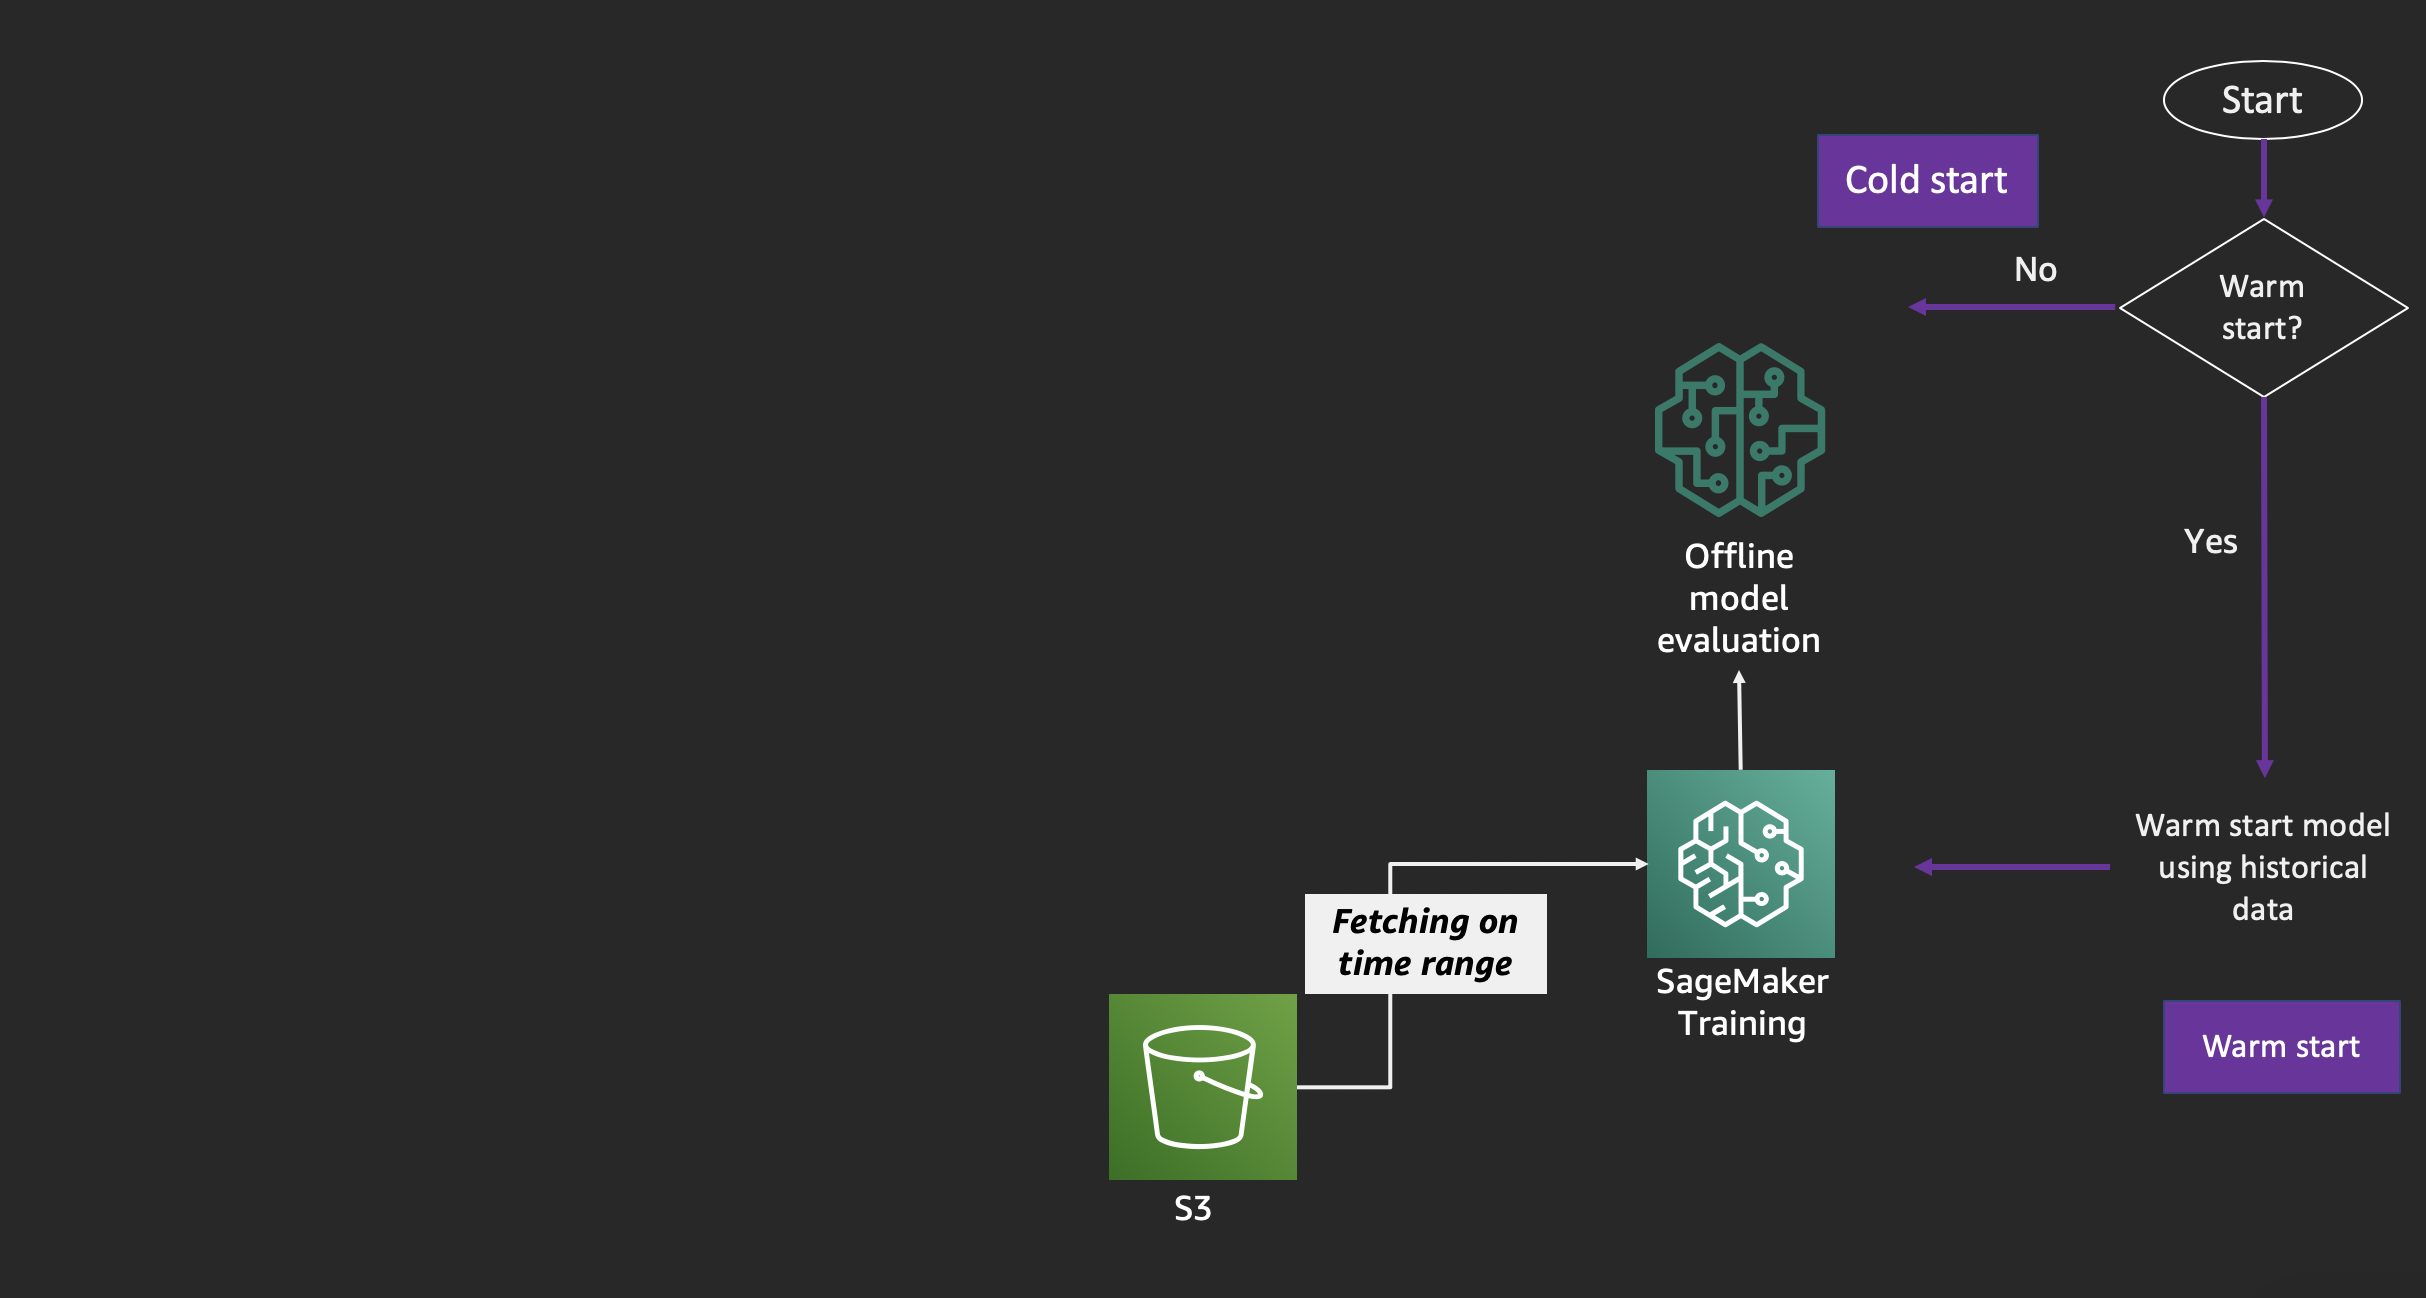

In [16]:
display(Image('images/AIM404-model-initialization-evaluate.png'))

In [17]:
# evaluate the current model by launching a training job on Sagemaker
bandits_experiment.evaluate_model(
    input_data_s3_prefix=bandits_experiment.last_joined_job_eval_data,
    evaluate_model_id=bandits_experiment.last_trained_model_id)

INFO:orchestrator:Evaluating model 'AIM404-sbs-model-id-1575490542' with evaluation job id 'AIM404-sbs-model-id-1575490542-eval-1575490765'
INFO:orchestrator:Evaluation job will be executed in 'SageMaker' mode


2019-12-04 20:19:25 Starting - Starting the training job...
2019-12-04 20:19:27 Starting - Launching requested ML instances......
2019-12-04 20:20:33 Starting - Preparing the instances for training...
2019-12-04 20:21:23 Downloading - Downloading input data
2019-12-04 20:21:23 Training - Downloading the training image.....

2019-12-04 20:22:07,699 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:22:09,117 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:22:09,129 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:22:09,139 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_estimator": "RLEstimator"
    },
    "channel_input_dirs": {
        "evaluation": "/opt/ml/input/data/evaluation",
        "pretrained_model": "/opt/ml/input/data/pretrained_model"
    },
    "current_host": "algo-1",
    "framework_module": null,
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "exploration_policy": "egreedy",
        "epsilon": 0.001,
        "num_arms": 7,
        "num_policies": 3,
        "cfa_type": "dr"
    },
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {
       

<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/sagemaker/home?force&region=us-east-1#/jobs?f0=kvm%253AName%253AAIM404-sbs">Sagemaker console</a> to understand what is happening during evaluation
</div>

<div class="alert alert-block alert-warning">

The Experiment manager uses the same estimator for evalution and training ==> [RLEstimator](https://sagemaker.readthedocs.io/en/stable/sagemaker.rl.html) 

The difference here is the custom code used as entry point for the container. It is now **eval-cfa-vw.py** in **src**

Once again, the evaluation of our model should be between 0 and 1. The smaller, the better
</div/>

In [18]:
# now get the evaluation score
eval_score_last_trained_model = bandits_experiment.get_eval_score(
    evaluate_model_id=bandits_experiment.last_trained_model_id,
    eval_data_path=bandits_experiment.last_joined_job_eval_data
)

INFO:orchestrator:Getting eval scores for model 'AIM404-sbs-model-id-1575490542' on eval data set 's3://sagemaker-us-east-1-573875878481/AIM404-sbs/joined_data/AIM404-sbs-join-job-id-1575490535/eval'
INFO:orchestrator:Evaluation score for model 'AIM404-sbs-model-id-1575490542'with data 's3://sagemaker-us-east-1-573875878481/AIM404-sbs/joined_data/AIM404-sbs-join-job-id-1575490535/eval' is 0.878855.


<div class="alert alert-block alert-warning">
Let's evaluate the model performance on our historical data set (here the warm start). First, we will download the file statlog_warm_start.data
</div/>

Download last joined data used for evaluation under **statlog_warm_start.data** file

In [19]:
download_historical_data_from_s3(data_s3_prefix=bandits_experiment.last_joined_job_eval_data)

Check what is inside

In [20]:
pd.read_csv("./statlog_warm_start.data", sep=',')

reward                 event_id  action  action_prob  \
0        0  not-apply-to-warm-start       4     0.142857   
1        0  not-apply-to-warm-start       4     0.142857   
2        0  not-apply-to-warm-start       7     0.142857   
3        1  not-apply-to-warm-start       1     0.142857   
4        1  not-apply-to-warm-start       1     0.142857   
5        0  not-apply-to-warm-start       7     0.142857   
6        0  not-apply-to-warm-start       6     0.142857   
7        0  not-apply-to-warm-start       3     0.142857   
8        0  not-apply-to-warm-start       7     0.142857   
9        0  not-apply-to-warm-start       3     0.142857   
10       1  not-apply-to-warm-start       4     0.142857   
11       0  not-apply-to-warm-start       5     0.142857   
12       0  not-apply-to-warm-start       6     0.142857   
13       0  not-apply-to-warm-start       7     0.142857   
14       0  not-apply-to-warm-start       6     0.142857   
15       0  not-apply-to-warm-start       2     0.142857   
16       0  not-apply-to-warm-start       3     0.142857   
17       0  not-apply-to-warm-start       3     0.142857   
18       1  not-apply-to-warm-start       1     0.142857   

                   model_id  \
0   not-apply-to-warm-start   
1   not-apply-to-warm-start   
2   not-apply-to-warm-start   
3   not-apply-to-warm-start   
4   not-apply-to-warm-start   
5   not-apply-to-warm-start   
6   not-apply-to-warm-start   
7   not-apply-to-warm-start   
8   not-apply-to-warm-start   
9   not-apply-to-warm-start   
10  not-apply-to-warm-start   
11  not-apply-to-warm-start   
12  not-apply-to-warm-start   
13  not-apply-to-warm-start   
14  not-apply-to-warm-start   
15  not-apply-to-warm-start   
16  not-apply-to-warm-start   
17  not-apply-to-warm-start   
18  not-apply-to-warm-start   

                                          observation  sample_prob  
0   [0.061199158032694094, -0.022742379839152938, ...     0.886116  
1   [-0.9182952246686029, -0.005493000761080599, -...     0.879668  
2   [0.14282368992446884, 0.01175637831699174, -0....     0.851257  
3   [-0.9182952246686029, -0.005493000761080599, -...     0.972811  
4   [0.6325708812751174, -0.005493000761080599, 0....     0.938248  
5   [-0.9182952246686029, -0.005493000761080599, -...     0.920505  
6   [0.3876972855997931, -0.005493000761080599, -0...     0.848253  
7   [-0.9182952246686029, -0.005493000761080599, -...     0.970371  
8   [0.6325708812751174, -0.005493000761080599, -1...     0.875617  
9   [0.3876972855997931, -0.07449051707336996, -0....     0.956682  
10  [0.6325708812751174, -0.005493000761080599, 1....     0.888080  
11  [0.6325708812751174, 0.04625513647313642, 1.19...     0.922193  
12  [0.6325708812751174, 0.0807538946292811, 1.309...     0.889139  
13  [0.5509463493833426, -0.005493000761080599, 0....     0.938115  
14  [-0.7550461608850534, -0.005493000761080599, 2...     0.984531  
15  [-0.591797097101504, -0.005493000761080599, -0...     0.989504  
16  [-0.9182952246686029, -0.005493000761080599, -...     0.970486  
17  [-0.9182952246686029, -0.005493000761080599, -...     0.911372  
18  [-0.02042537385908066, -0.05724113799529761, -...     0.871612

In [21]:
# get baseline performance from the historical (warm start) data (cost = 1-mean(reward))
baseline_score = evaluate_historical_data(data_file='statlog_warm_start.data')
baseline_score

0.7894736842105263

Now we can compare the value from **eval_score_last_trained_model** with the **baseline_score**. Can you see an improvement? :)

In [22]:
# Check the model_id of the last model trained.
bandits_experiment.last_trained_model_id

'AIM404-sbs-model-id-1575490542'

In [23]:
pp.pprint(bandits_experiment._jsonify())

{   'evaluation_workflow_metadata': {   'evaluation_state': 'EVALUATED',
                                        'last_evaluation_job_id': 'AIM404-sbs-model-id-1575490542-eval-1575490765',
                                        'next_evaluation_job_id': None},
    'experiment_id': 'AIM404-sbs',
    'hosting_workflow_metadata': {   'hosting_endpoint': None,
                                     'hosting_state': None,
                                     'last_hosted_model_id': None,
                                     'next_model_to_host_id': None},
    'joining_workflow_metadata': {   'joining_state': 'SUCCEEDED',
                                     'last_joined_job_id': 'AIM404-sbs-join-job-id-1575490535',
                                     'next_join_job_id': None},
    'training_workflow_metadata': {   'last_trained_model_id': 'AIM404-sbs-model-id-1575490542',
                                      'next_model_to_train_id': None,
                                      'training_st

<div class="alert alert-block alert-success">
    So far, we uploaded data on S3, trained a model on this dataset and evaluated it.</div>

### 2. Deploy the First Model

Once training and evaluation is done, we can deploy the model.

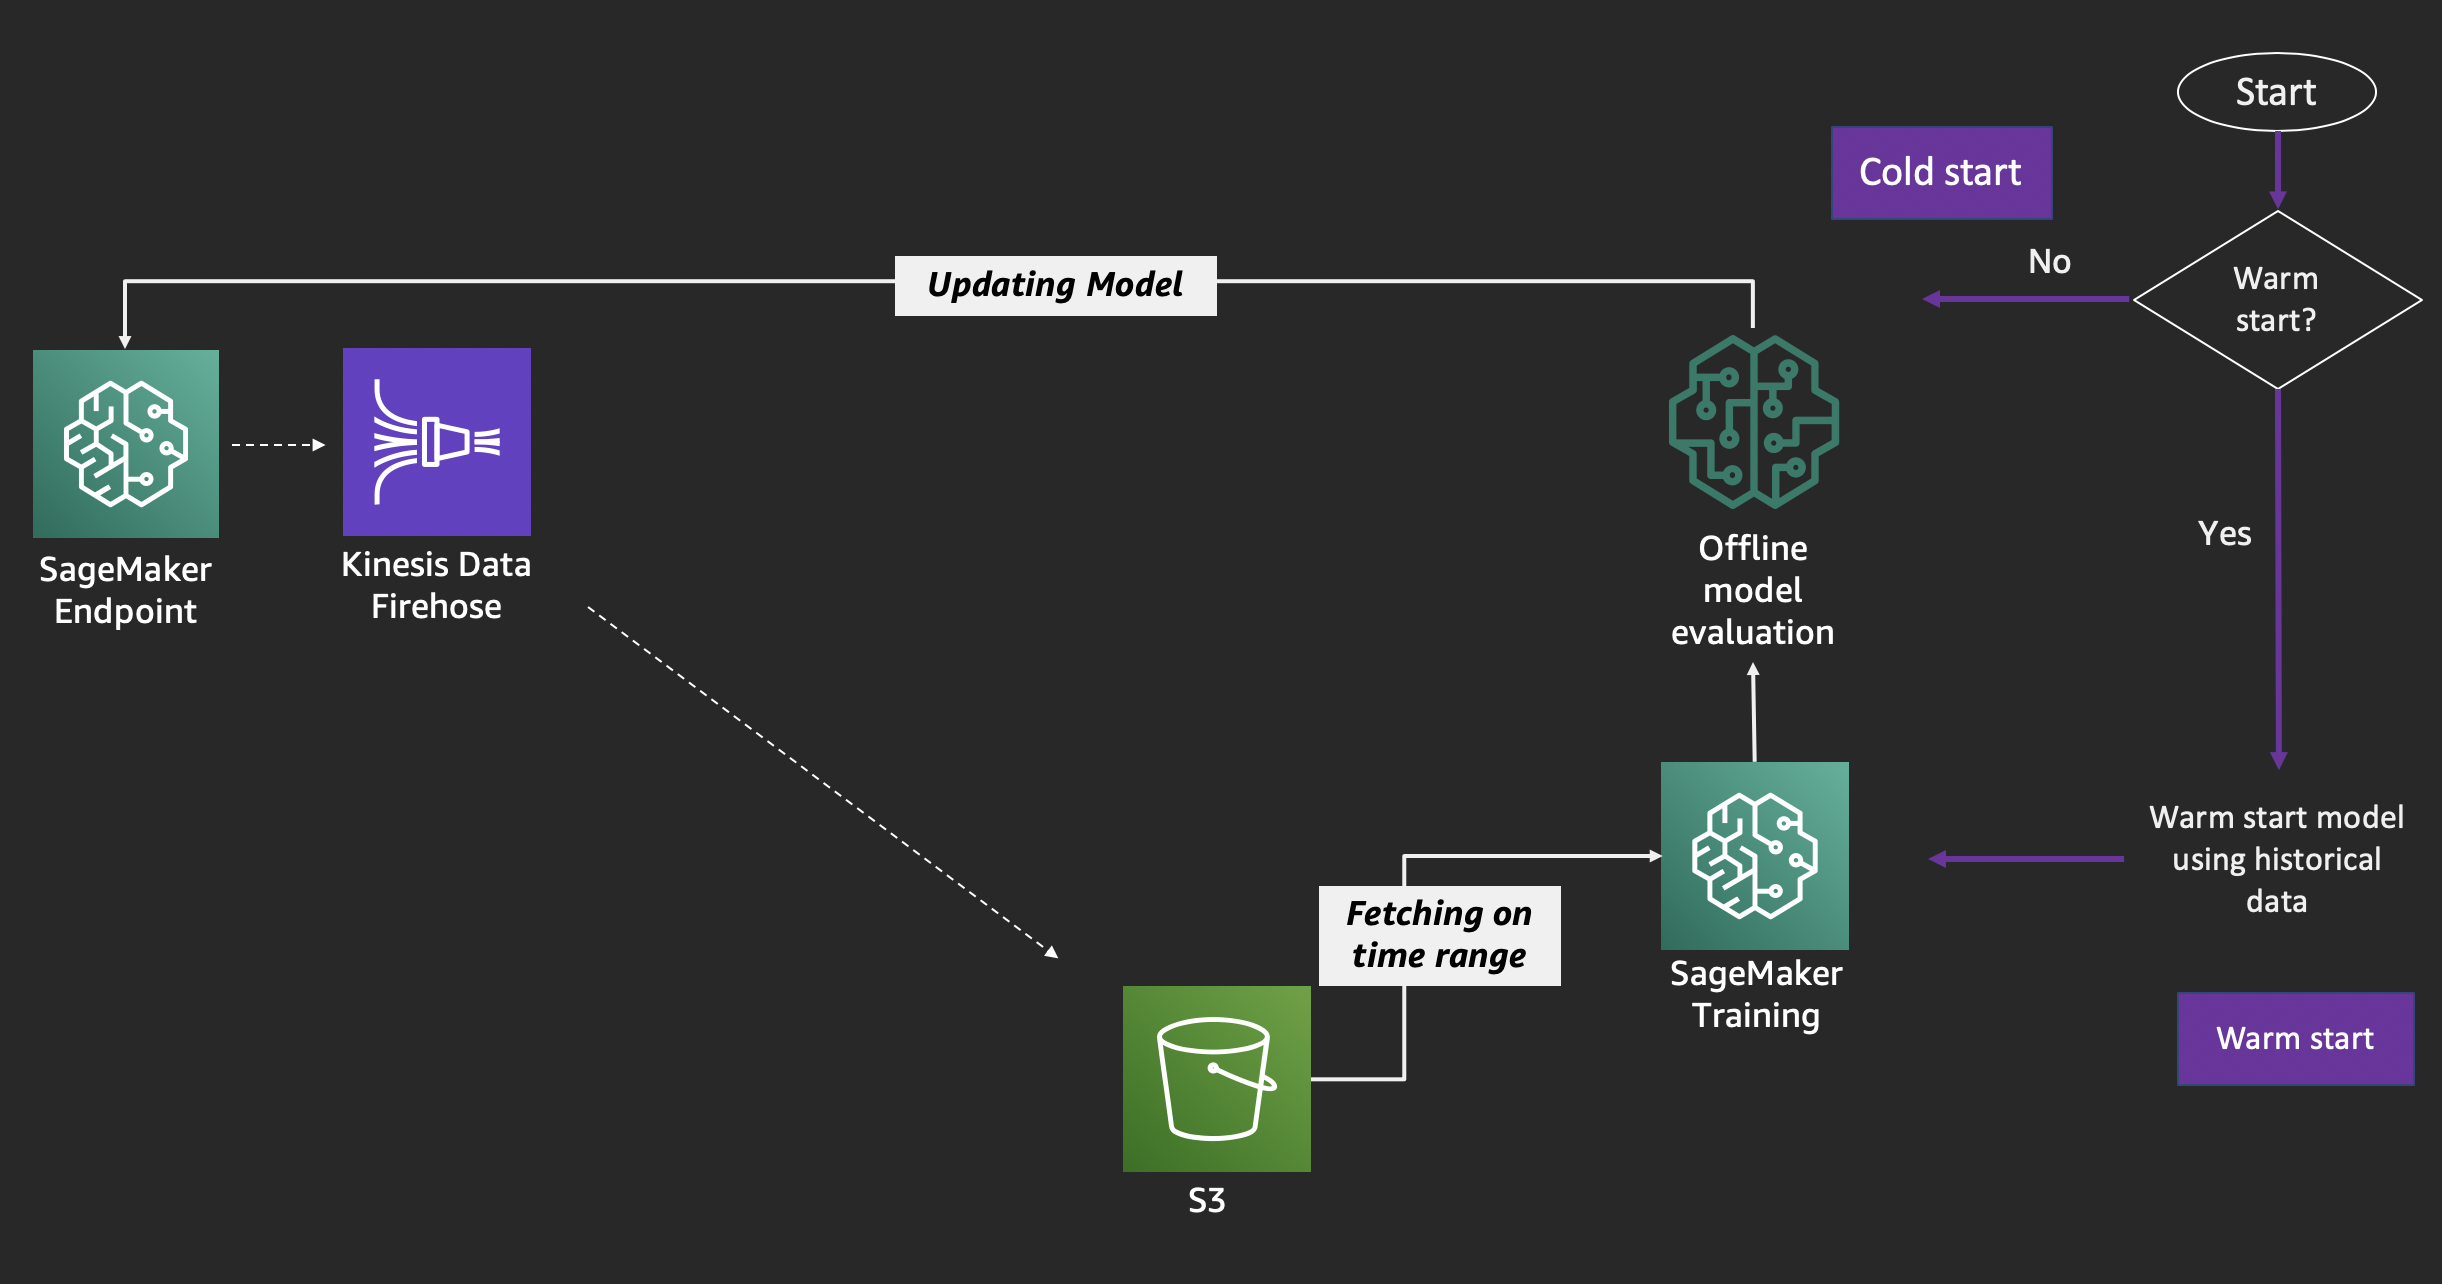

In [24]:
display(Image('images/AIM404-model-initialization-deploy.png'))

In [25]:
bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id) 

INFO:orchestrator:Model 'AIM404-sbs-model-id-1575490542' is ready to deploy.
INFO:orchestrator:No hosting endpoint found, creating a new hosting endpoint.
INFO:orchestrator.resource_manager:Successfully create S3 bucket 'sagemaker-us-east-1-573875878481' for storing sagemaker data
INFO:orchestrator.resource_manager:Creating firehose delivery stream...
INFO:orchestrator.resource_manager:Creating firehose delivery stream...
INFO:orchestrator.resource_manager:Creating firehose delivery stream...
INFO:orchestrator.resource_manager:Creating firehose delivery stream...
INFO:orchestrator.resource_manager:Successfully created delivery stream 'AIM404-sbs'


---------------------------------------------------------------------------------------------------------------------------!

<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/sagemaker/home?force&region=us-east-1#/endpoints?f0=kvm%253AName%253AAIM404-sbs">Sagemaker Endpoint</a>
</div>

<div class="alert alert-block alert-warning">

SageMaker hosting endpoint saves all the inferences `<eventID, state, action, action probability>` to S3 using [Kinesis Firehose](https://aws.amazon.com/kinesis/data-firehose/)

This firehose stream is created during endopint deployment.


The Experiment manager creates the sagemaker endpoint by using the method [Model](https://sagemaker.readthedocs.io/en/stable/model.html) from Sagemaker SDK.
</div/>

<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/firehose/home?region=us-east-1#/dashboard/list">Kinesis Firehose Console</a>
</div>

You can check the experiment state at any point by executing:

In [26]:
pp.pprint(bandits_experiment._jsonify())

{   'evaluation_workflow_metadata': {   'evaluation_state': 'EVALUATED',
                                        'last_evaluation_job_id': 'AIM404-sbs-model-id-1575490542-eval-1575490765',
                                        'next_evaluation_job_id': None},
    'experiment_id': 'AIM404-sbs',
    'hosting_workflow_metadata': {   'hosting_endpoint': 'arn:aws:sagemaker:us-east-1:573875878481:endpoint/aim404-sbs',
                                     'hosting_state': 'DEPLOYED',
                                     'last_hosted_model_id': 'AIM404-sbs-model-id-1575490542',
                                     'next_model_to_host_id': None},
    'joining_workflow_metadata': {   'joining_state': 'SUCCEEDED',
                                     'last_joined_job_id': 'AIM404-sbs-join-job-id-1575490535',
                                     'next_join_job_id': None},
    'training_workflow_metadata': {   'last_trained_model_id': 'AIM404-sbs-model-id-1575490542',
                            

The model just trained appears in both `last_trained_model_id` and `last_hosted_model_id`.

<div class="alert alert-block alert-success">
    Now we deployed a Sagemaker Endpoint to interactively request it.</div>

### 3. Initialize the Client Application

Now that the last trained model is hosted, client application can send out the state, hit the endpoint, and receive the recommended action. There are 7 classes in the statlog data, corresponding to 7 actions respectively.

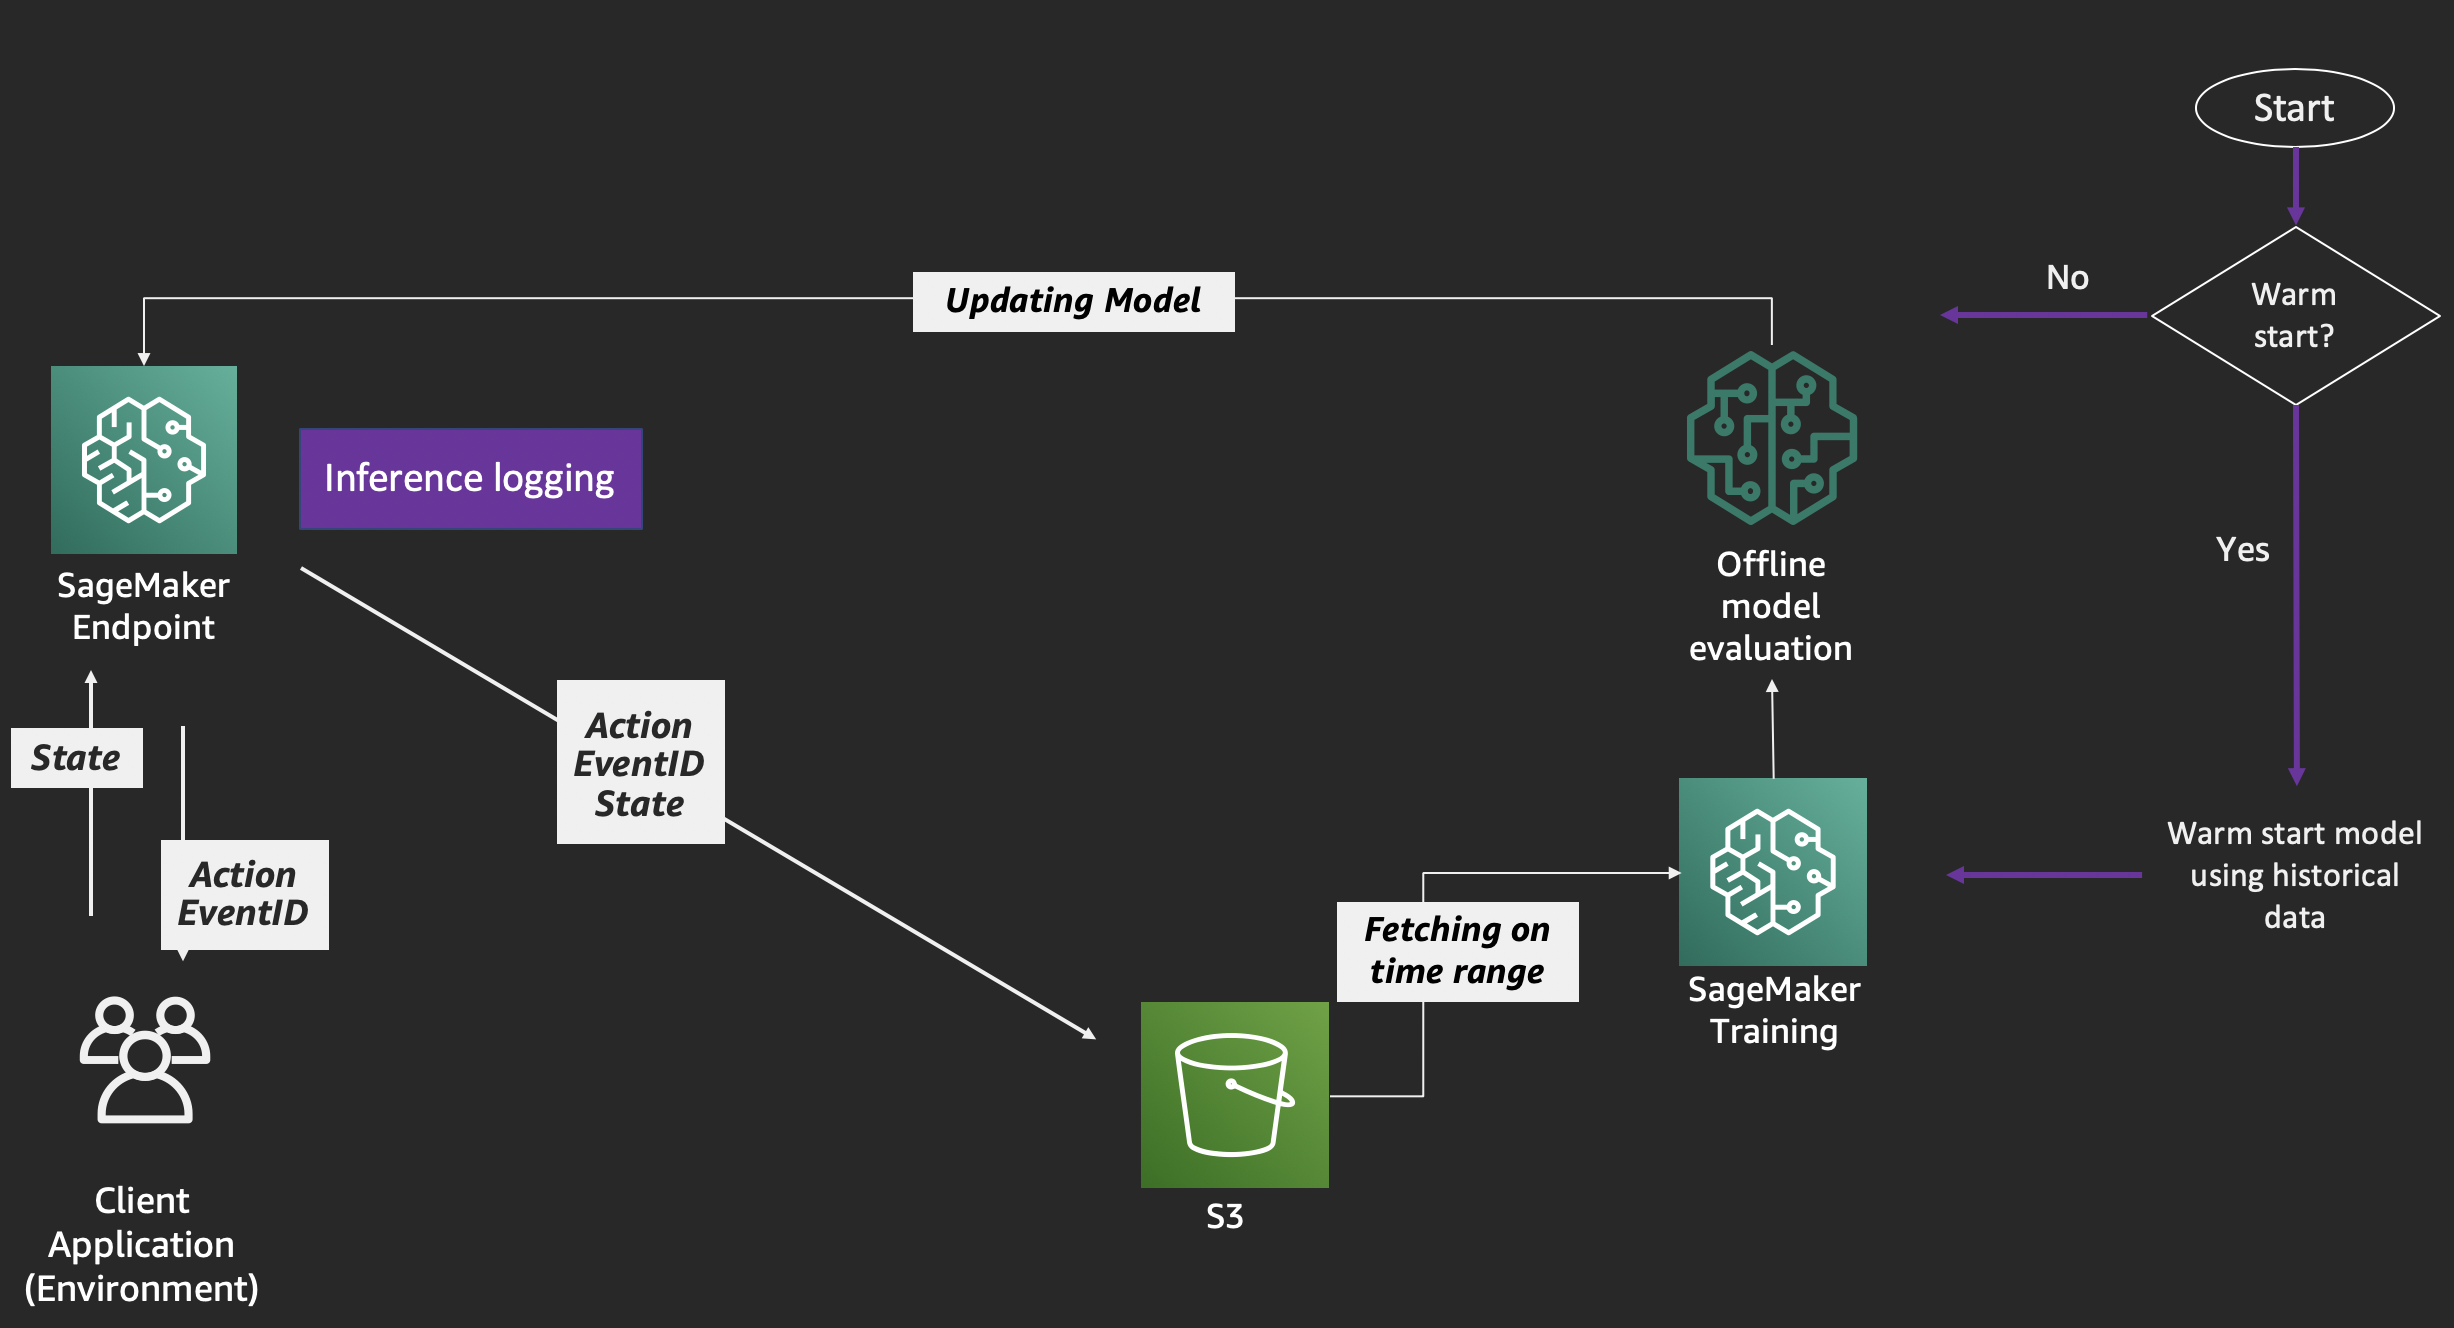

In [27]:
display(Image('images/AIM404-inference.png'))

<div class="alert alert-block alert-warning">

Here we use the [Predictor](https://sagemaker.readthedocs.io/en/stable/predictors.html) class from Sagemaker Python SDK.
</div/>

In [28]:
predictor = bandits_experiment.predictor

In [29]:
sim_app = StatlogSimApp(predictor=predictor)

Unique classes and their ratio of total: {0: 0.7840919540229885, 1: 0.0008505747126436781, 2: 0.0030344827586206895, 3: 0.1551264367816092, 4: 0.05650574712643678, 5: 0.00013793103448275863, 6: 0.0002528735632183908}


Make sure that `num_arms` specified in `config.yaml` is equal to the total unique actions in the simulation application.

In [30]:
assert sim_app.num_actions == bandits_experiment.config["algor"]["algorithms_parameters"]["num_arms"]

In [31]:
user_id, user_context = sim_app.choose_random_user()
action, event_id, model_id, action_prob, sample_prob = predictor.get_action(obs=user_context)

# Check prediction response by uncommenting the lines below
print('Selected action: {}, event ID: {}, model ID: {}, probability: {}'.format(action, event_id, model_id, action_prob))

Selected action: 1, event ID: 145224088932988832853884726869165670402, model ID: AIM404-sbs-model-id-1575490542, probability: 0.999142000857999


<div class="alert alert-block alert-success">
    Here we simulated a client request to the sagemaker endpoint with the get_action() method that sends context to the sagemaker endpoint</div>

### 4. Reward Ingestion

Client application generates a reward after receiving the recommended action and stores the tuple `<eventID, reward>` in S3. In this case, reward is 1 if predicted action is the true class, and 0 otherwise. . The experiment manager joins the reward with state, action and action probability using [Amazon Athena](https://aws.amazon.com/athena/). 

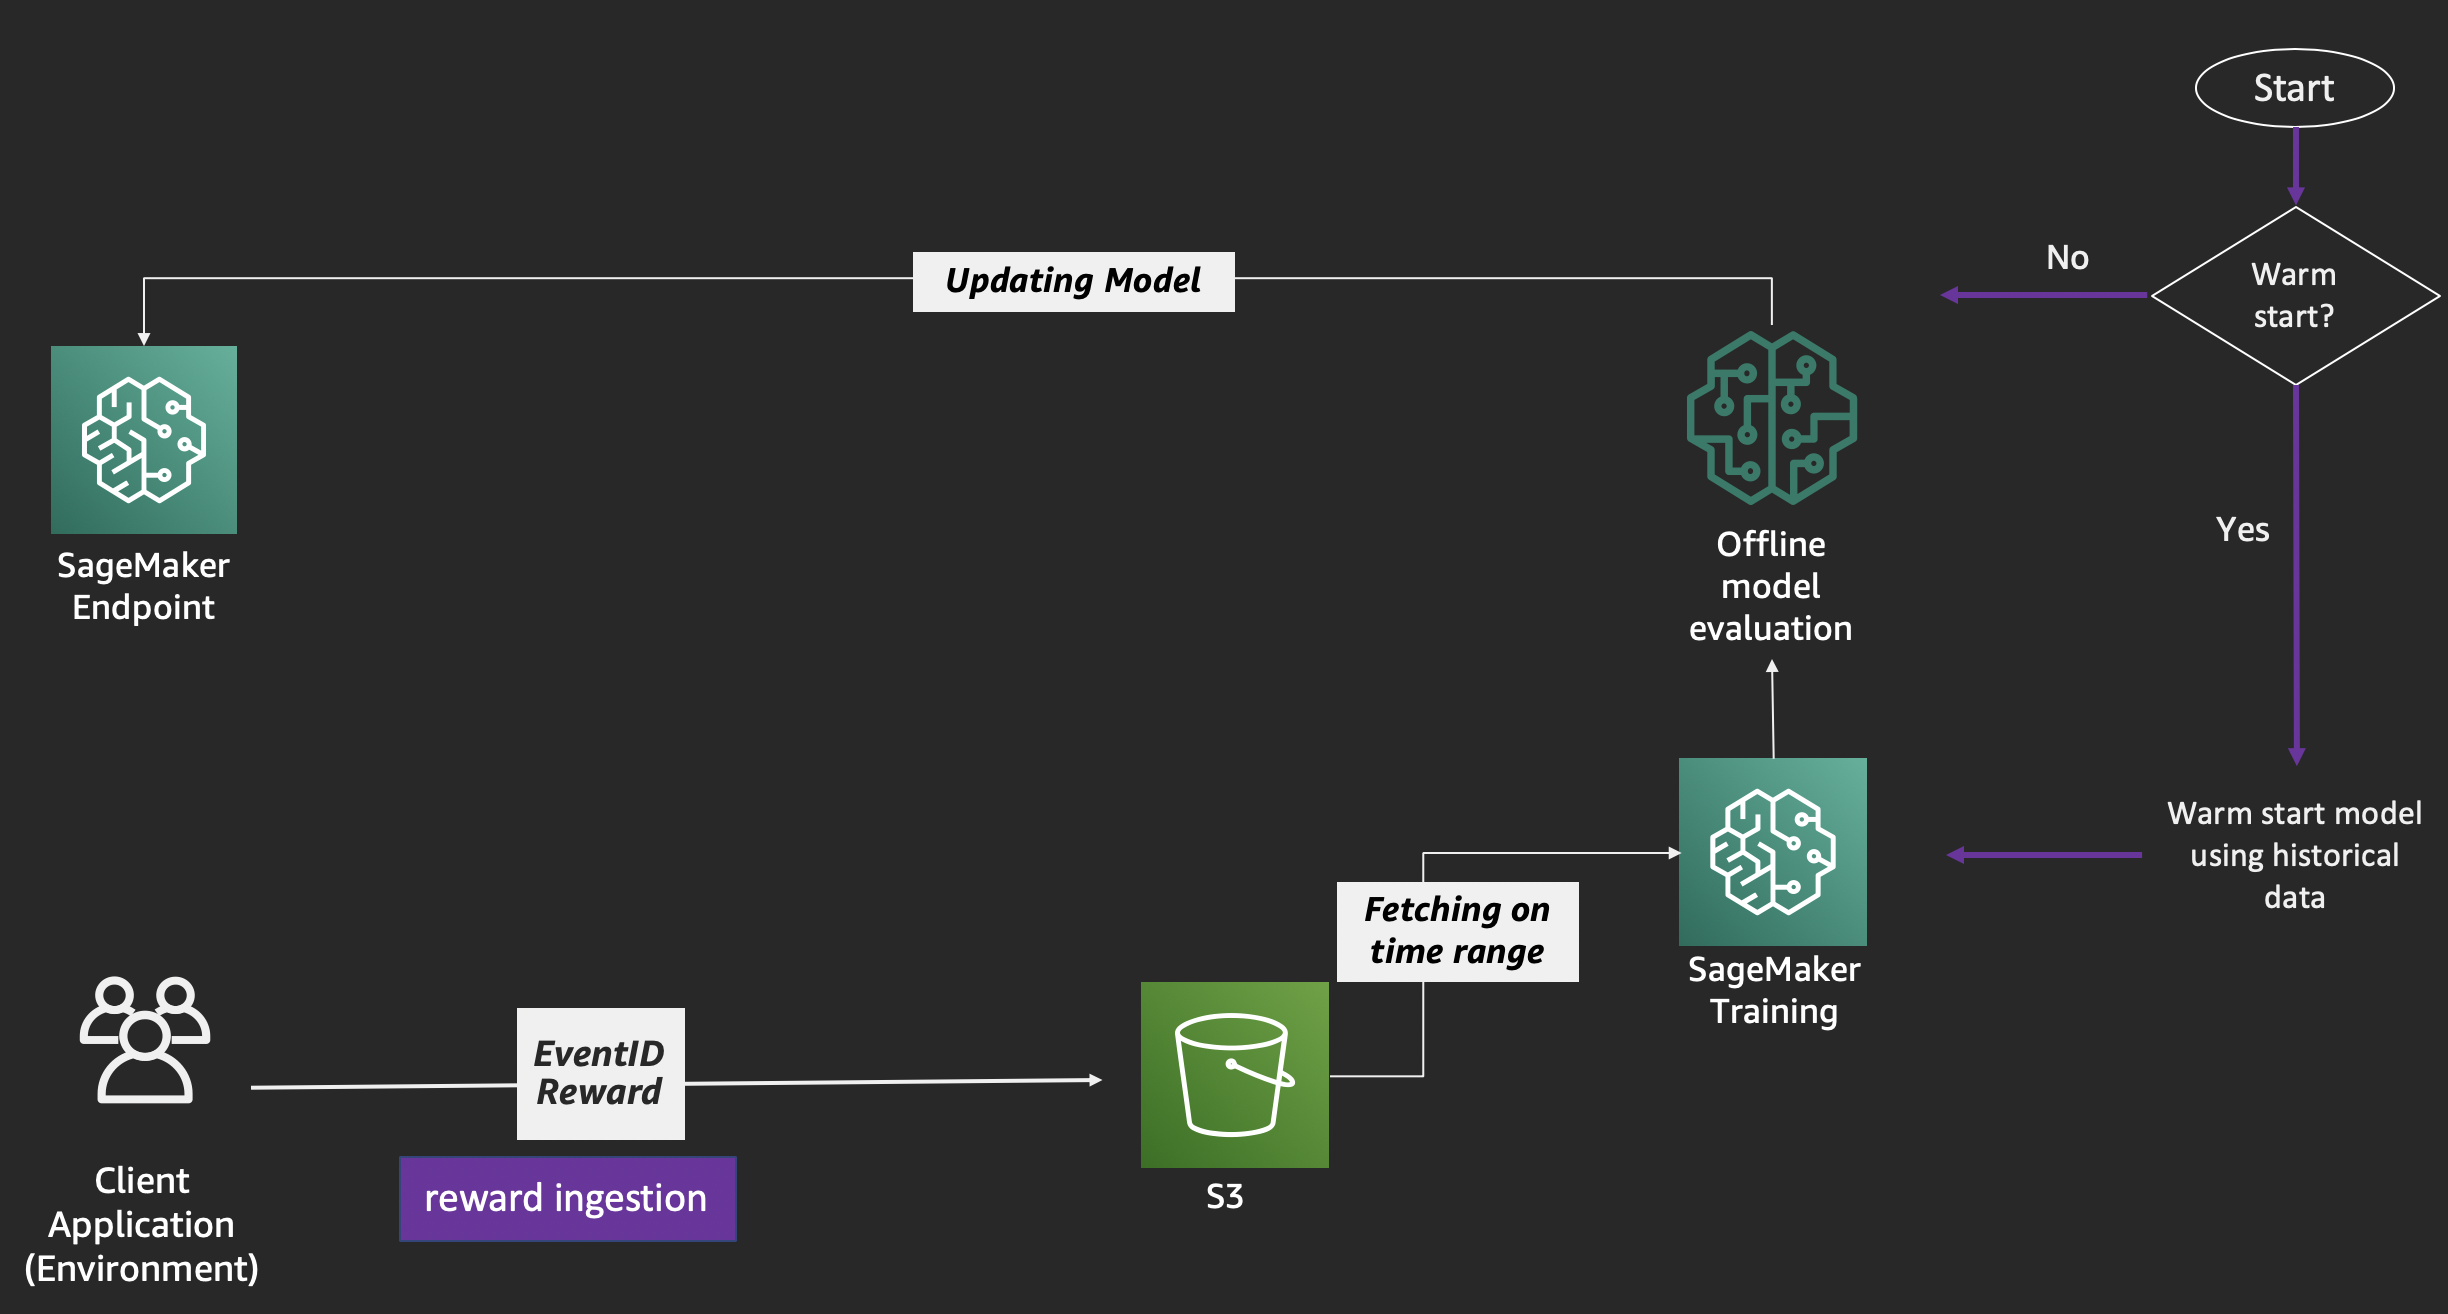

In [32]:
display(Image('images/AIM404-reward.png'))

In [33]:
local_mode = bandits_experiment.local_mode
batch_size = 500 # collect 500 data instances
print("Collecting batch of experience data...")

# Generate experiences and log them
for i in range(batch_size):
    user_id, user_context = sim_app.choose_random_user()
    action, event_id, model_id, action_prob, sample_prob = predictor.get_action(obs=user_context.tolist())
    reward = sim_app.get_reward(user_id, action, event_id, model_id, action_prob, sample_prob, local_mode)

#### Aggregate Inference data with rewards data

<div class="alert alert-block alert-warning">

Once data from inference and reward phase are on S3, we need to start aggregate this data to the following format : `<eventID, state, action, action probability, reward>`.

This step is done with [Amazon Athena](https://aws.amazon.com/athena/)
</div/>

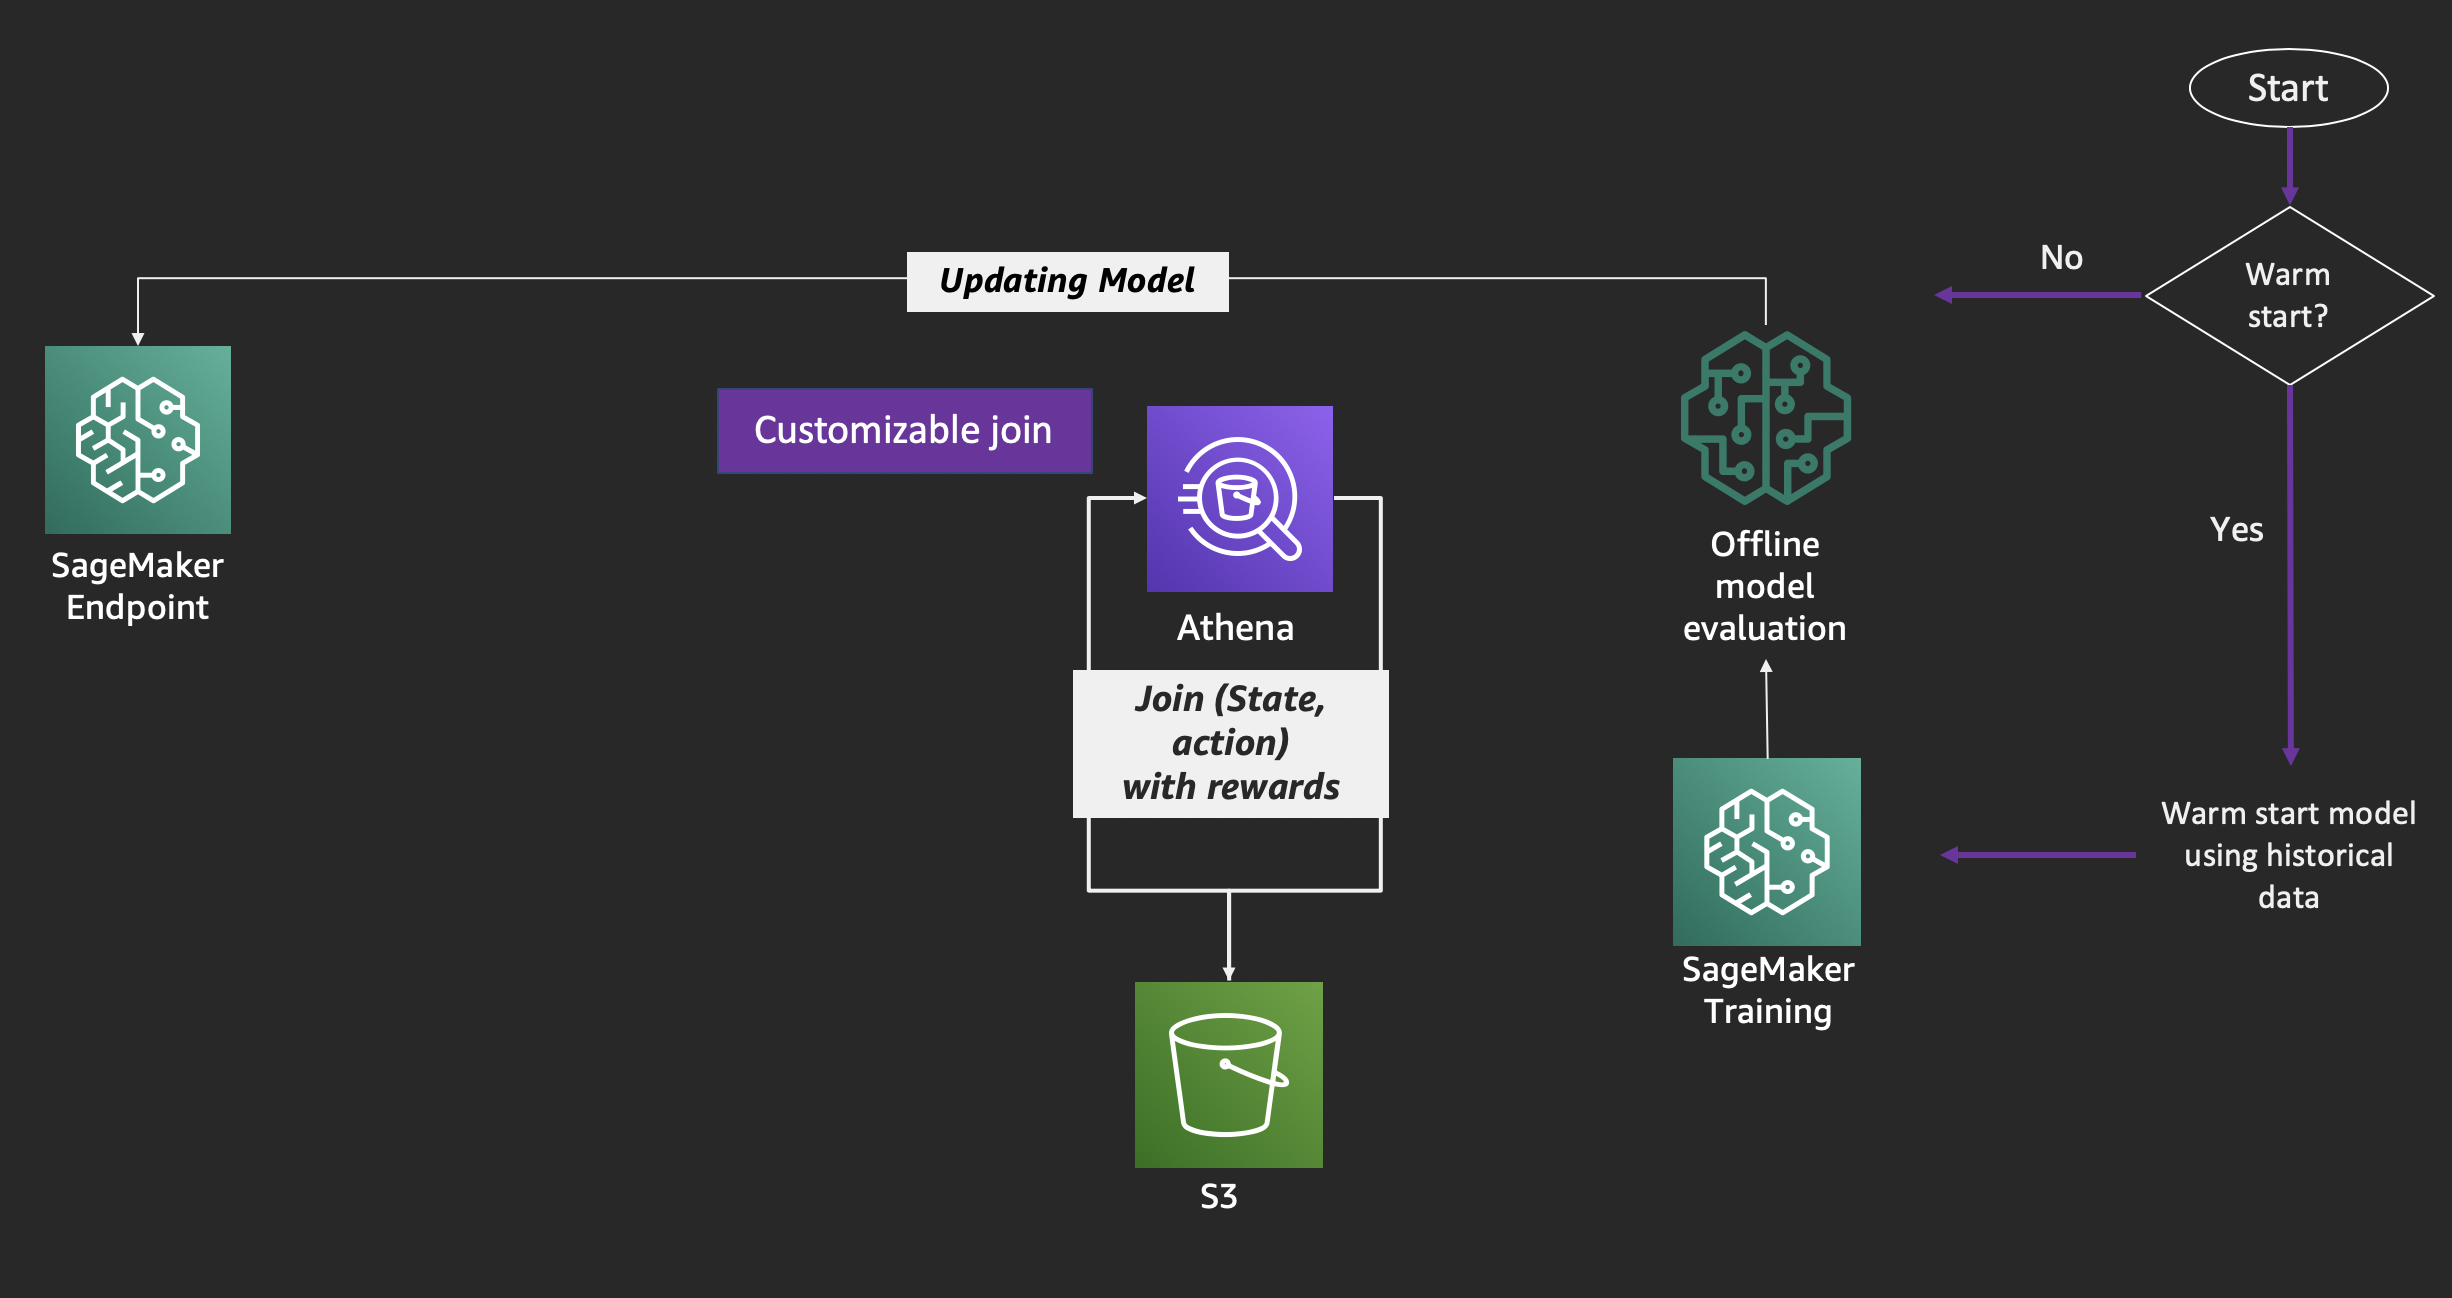

In [34]:
display(Image('images/AIM404-join.png'))

In [35]:
# Join (observation, action) with rewards (can be delayed) and upload the data to S3
if local_mode:
    bandits_experiment.ingest_joined_data(sim_app.joined_data_buffer)
else:
    print("Waiting for firehose to flush data to s3...")
    time.sleep(60) # Wait for firehose to flush data to S3 - actually the VW container image take as a venv the firehose stream name
    rewards_s3_prefix = bandits_experiment.ingest_rewards(sim_app.rewards_buffer)
    print(rewards_s3_prefix)
    bandits_experiment.join(rewards_s3_prefix)
    
sim_app.clear_buffer()

Waiting for firehose to flush data to s3...


INFO:orchestrator.resource_manager:Successfully create S3 bucket 'sagemaker-us-east-1-573875878481' for storing sagemaker data
INFO:orchestrator:Waiting for reward data to be uploaded.
INFO:orchestrator:Successfully upload reward files to s3 bucket path s3://sagemaker-us-east-1-573875878481/AIM404-sbs/rewards_data/AIM404-sbs-1575491718/rewards-1575491718
INFO:orchestrator:Creating resource for joining job...


s3://sagemaker-us-east-1-573875878481/AIM404-sbs/rewards_data/AIM404-sbs-1575491718


INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-573875878481' for athena queries
INFO:orchestrator:Started joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.8
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-east-1-573875878481/AIM404-sbs/joined_data/AIM404-sbs-join-job-id-1575491718


<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/athena/home?force&region=us-east-1#query">Athena console</a> and check history console to look at the different requests.
</div>

In [36]:
bandits_experiment.last_joined_job_train_data

's3://sagemaker-us-east-1-573875878481/AIM404-sbs/joined_data/AIM404-sbs-join-job-id-1575491718/train'

In [37]:
# Check the workflow to see if join job has completed successfully
pp.pprint(bandits_experiment._jsonify())

{   'evaluation_workflow_metadata': {   'evaluation_state': 'EVALUATED',
                                        'last_evaluation_job_id': 'AIM404-sbs-model-id-1575490542-eval-1575490765',
                                        'next_evaluation_job_id': None},
    'experiment_id': 'AIM404-sbs',
    'hosting_workflow_metadata': {   'hosting_endpoint': 'arn:aws:sagemaker:us-east-1:573875878481:endpoint/aim404-sbs',
                                     'hosting_state': 'DEPLOYED',
                                     'last_hosted_model_id': 'AIM404-sbs-model-id-1575490542',
                                     'next_model_to_host_id': None},
    'joining_workflow_metadata': {   'joining_state': 'SUCCEEDED',
                                     'last_joined_job_id': 'AIM404-sbs-join-job-id-1575491718',
                                     'next_join_job_id': None},
    'training_workflow_metadata': {   'last_trained_model_id': 'AIM404-sbs-model-id-1575490542',
                            

<div class="alert alert-block alert-success">
    Here we ingested data from the simulated client and aggregated it with the inference data</div>

### 5. Model Re-training and Re-deployment

Now we can train a new model with newly collected experiences, and host the resulting model.

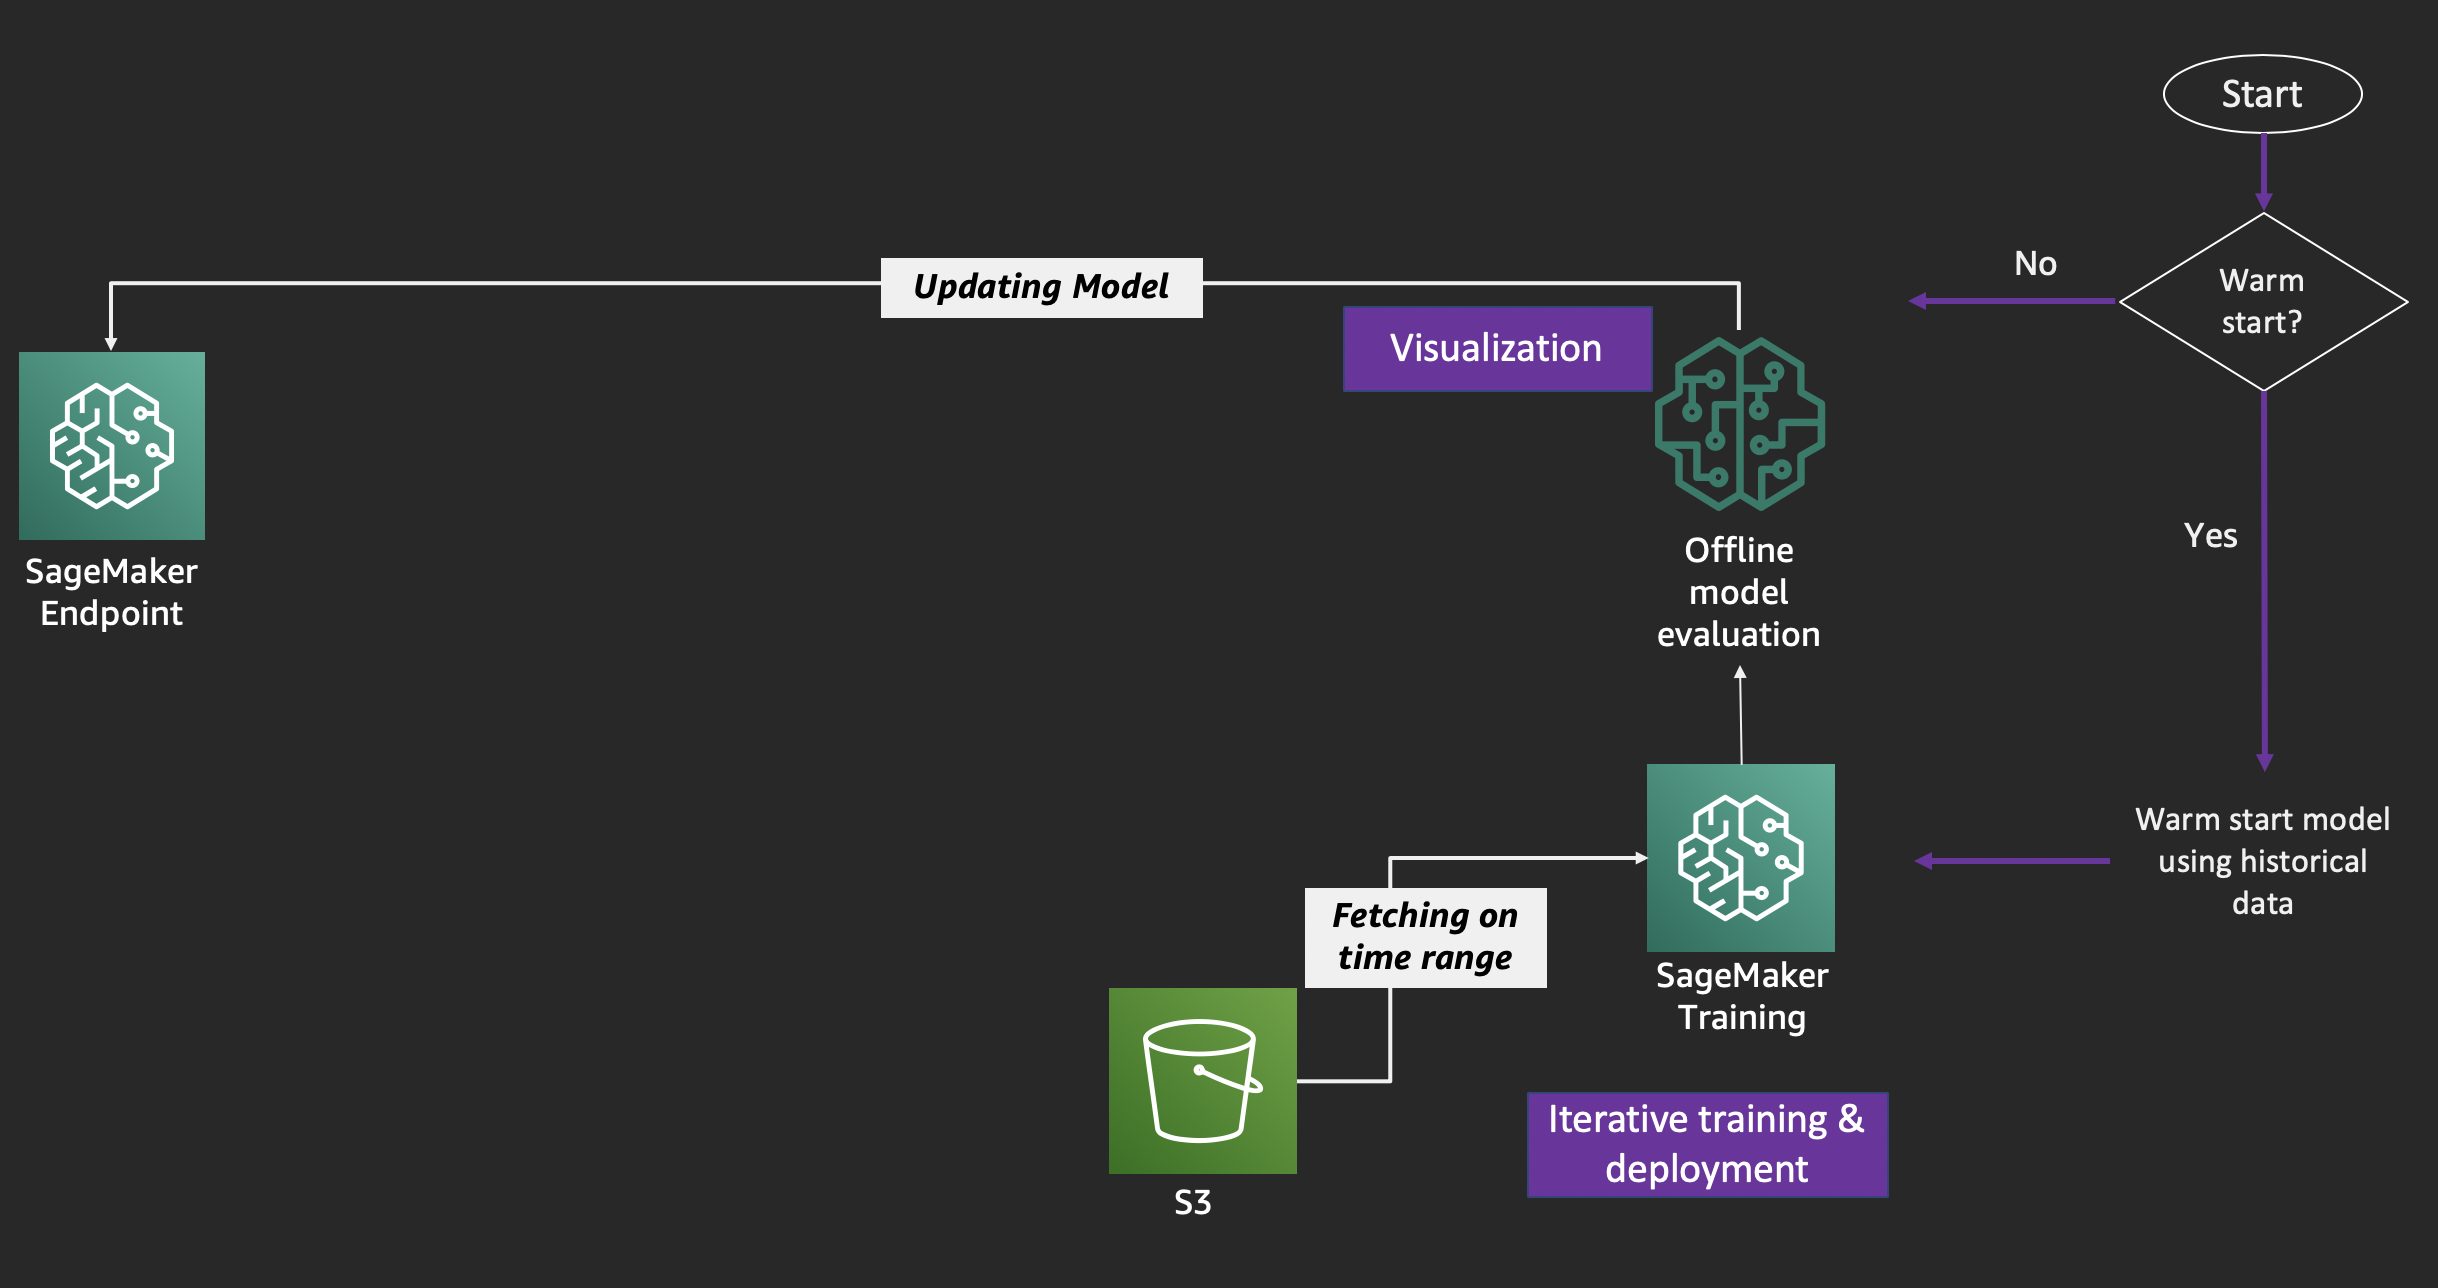

In [38]:
display(Image('images/AIM404-model-retraining.png'))

In [39]:
bandits_experiment.train_next_model(input_data_s3_prefix=bandits_experiment.last_joined_job_train_data)

INFO:orchestrator:Use last trained model AIM404-sbs-model-id-1575490542 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'AIM404-sbs-model-id-1575491775''
INFO:orchestrator:Training job will be executed in 'SageMaker' mode


2019-12-04 20:36:16 Starting - Starting the training job...
2019-12-04 20:36:17 Starting - Launching requested ML instances......
2019-12-04 20:37:22 Starting - Preparing the instances for training...
2019-12-04 20:38:13 Downloading - Downloading input data
2019-12-04 20:38:13 Training - Downloading the training image......
2019-12-04 20:39:15 Uploading - Uploading generated training model2019-12-04 20:39:03,900 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:39:10,123 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:39:10,135 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-04 20:39:10,144 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_estimator": "RLEstimator"
    },
    "channel_input_dirs": {
        "pretrained_model": "/opt/ml/input/data/pretrained_model",
        "training": "/op

<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/sagemaker/home?force&region=us-east-1#/jobs?f0=kvm%253AName%253AAIM404-sbs">Sagemaker Training Jobs console</a>
</div>

In [40]:
bandits_experiment.last_trained_model_id

'AIM404-sbs-model-id-1575491775'

#### Blue/Green Deployment

Now we will update the model behind the same sagemaker endpoint. We can check how blue/green deployment works on Sagemaker by analysing the following elements : 
    - Sagemaker Endpoints
    - Sagemaker Endpoint Configurations
    - Sagemaker Models
    
To check no error is happening during the blue/green deployment phase, you will send inference requests to the endpoint through a loop. 

<div class="alert alert-block alert-danger"">
To do so, go to the following notebooks <a href="./Inference%20loop.ipynb"> Inference Loop </a>
</div>

Now you can start the deployment of the newly trained model and follow that everything is ok through Cloudwatch

<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/sagemaker/home?force&region=us-east-1#/endpoints/AIM404-sbs">Sagemaker Endpoints console</a>
</div>

<div class="alert alert-block alert-danger"">
<ul>
<li>Clink on your Sagemaker Endpoint</li>
<li>Under Monitor, click <b>View Invocation metrics</b>. This will open cloudwatch console</li>
                                            <li>Select Metric Name <b>Invocations</b> for your endpoint</li>
<li>Go to Graphed metrics tab</li>
                                            <li>Set Statistic to sum, period to 10 seconds</li>
                                            <li>On the upper right, select custom 5 min and select stacked instead of line</li>                                            
</ul>                                       
</div>

In [41]:
# deployment takes ~10 min if `local_mode` is False
bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)

INFO:orchestrator:Model 'AIM404-sbs-model-id-1575491775' is ready to deploy.
INFO:orchestrator.resource_manager:Successfully create S3 bucket 'sagemaker-us-east-1-573875878481' for storing sagemaker data


<div class="alert alert-block alert-info">
§ Open the <a href="https://us-east-1.console.aws.amazon.com/sagemaker/home?force&region=us-east-1#/endpoints">Sagemaker Endpoints console</a>
</div>

In [42]:
bandits_experiment.last_hosted_model_id

'AIM404-sbs-model-id-1575491775'

<div class="alert alert-block alert-success">
    In this step, we deployed the new model version using sagemaker Blue/Green deployment method</div>

<a id='end-to-end'></a>
## Bandits model deployment with the end-to-end loop

 <div class="alert alert-block alert-danger"">
Go to the End-to-End notebook for the end of the workshop <a href="./AIM404-End_2_end_loop.ipynb"> AIM404-End_2_end_loop </a>
</div>

<a id='clean-up'></a>
## Clean up

We have three DynamoDB tables (experiment, join, model) from the bandits application above (e.g. `experiment_id='bandits-exp-1'`). To better maintain them, we should remove the related records if the experiment has finished. Besides, having an endpoint running will incur costs. Therefore, we delete these components as part of the clean up process.

<div class="alert alert-block alert-warning">

Only execute the clean up cells below when you've finished the current experiment and want to deprecate everything associated with it. After the cleanup, the Cloudwatch metrics will not be populated anymore. 
</div/>

In [43]:
bandits_experiment.clean_resource(experiment_id=bandits_experiment.experiment_id)

INFO:orchestrator:Deleting athena tables for 'AIM404-sbs'...
INFO:orchestrator:Successfully create S3 bucket 'sagemaker-us-east-1-573875878481' for athena queries
INFO:orchestrator:Deleting hosting endpoint 'AIM404-sbs'...


<div class="alert alert-block alert-success">
    The command <b>clean_resource( )</b> deletes : 
<ul>
    <li>kinesis firehose</li>
    <li>the external table created by Athena</li>
    <li>sagemaker endpoint</li>
    <li>sagemaker endpoint configuration</li>
    </ul>
</div>

In [44]:
bandits_experiment.clean_table_records(experiment_id=bandits_experiment.experiment_id)

<div class="alert alert-block alert-success">
    The command <b>clean_table_records( )</b> clean items from dynamoDB tables
</div>

In [45]:
1+2

3